# UK RBC Project

By Joel Thomas, Elif Çanga, and Kenan Topalovic.

This paper aims to compute and forcast a Real Business Cycle Model for the UK economy between the years 1960 to 2022. 

## Literature Review

This paper uses the DSGE (Dynamic General Stochastic Equilibrium) approach to analyze post-war UK business cycles between 1960 and 2022. The motivation of this paper is to provide credible policy advice for future studies and decisions. By processing the data collected (see data and calibration section), we tried to analyze the dynamics of UK business cycles, and build a model to capture all the output components comprehensively. Considering productivity shocks, we estimate steady-state value and generate impulse response functions using the MLE Kalman prediction method. We use a simple RBC model which includes 9 equations, 9 variables, 1 stochastic shock, and 6 parameters that are calibrated for the model to fit the data. 

In past studies, a wide variety of model assumptions have been adopted to better explain UK business cycles. Harrison and Oomen (2010) adopted a small open economy DSGE model with two-stage estimation spanning the years 1955- 2007. Initially, they calculated a calibrated version of a stochastically singular model which includes seven UK macroeconomic variables: consumption, total hours worked, investment, inflation, nominal interest rates, real wages, and output. Then, they upgrade the model with structural shocks triggered by the results of the evaluation stage and estimate the model results using Bayesian calculation. They evaluate the goodness-of-fit of this upgraded and estimated log-linearised model harmonizing the dynamics of the model with the data. Hence, they find that the calibrated model does not accurately capture the dynamics of the UK data and that the nominal interest rate and inflation rate are among the worst-fitting variables. 

Holland and Scott (1996) used an extended stochastic growth model to estimate productivity and preference shocks that are highly persistent and volatile for the sake of identifying the post-war UK business cycles. By dividing these two shocks, they find that while productivity shocks are more significant for UK output fluctuations, the estimated preference shift of the model is important in terms of employment movements. Another finding is that employment tends to lag production whereas consumption, investment, total, and average hours all peak jointly with GDP. According to business cycle facts, the investment appears to be the most volatile macroeconomic component with a standard deviation of 3.91. Notably, the real wage demonstrates no clear cyclical pattern. After the comparison with the US, they find that as opposed to the United States, where the extensive margin dominates, the volatility in total hours worked is evenly distributed between the intensive (average hours) and extensive (employment) margins.

Ravn (1997) investigates UK business cycle properties using the Vector Autoregression (VAR) technique. The production technology is modelled by two shocks of a permanent change in labor productivity and transitionary change in productivity. After analyzing the dynamic behavior of output, consumption, investment, and hours worked, Ravn comes up with the argument that while the model explains precisely the elasticities of expected changes in investment and consumption, the moments of hours worked cannot be explained being the main difference between theory and the data. Thus, the main problem of the model is the behavior of labor markets since the elasticity of expected changes in hours worked is relatively more controlled by expected changes than output components. That is the main difference between the UK moments and the US moments in the model as the latter is more stable across horizons regarding the elasticity of expected changes in hours with respect to expected changes in output. While the model can explain 60-70% of the variation observed in the data at short horizons, this ratio decreased to 25% as horizons get extended. That is to say, the persistence of hours worked in the UK is supposed to be higher in the model regarding the data in which the first-order autocorrelation of hours worked is around 0.98 while it is only 0.72 in the model.

## Preliminaries

In [3]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import statsmodels.api as sm

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

In [4]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names


def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

In [5]:
import statsmodels.api as sm

## The Model


### Calibration and Data

Estimation of the model below requires quarterly data on consumption, investment, rental rate of capital, GDP, labour and wage.
For consumption, we collected the 'Private Final Consumption Expenditure' in the UK from 1960 Q1 to 2022 Q2. Investment was collected as the 'Gross Fixed Capital Formation' in the UK, again for the period 1960 Q1 to 2022 Q2. No data is directly available for the rental rate of capital, but we used the proxy of 90-day London Interbank rates for the UK. This data could only be collected from 1986 Q1. Consumption, investment and the rental rate of capital were all sourced from the Federal Reserve Bank of St Louis (FRED, 2022).
GDP (in millions of pounds) was easy to collect from 1960 Q1, and we used the Office of National Statistics (ONS, 2022). We also used the Office of National Statistics for hours worked (Labour) and average wage per hour (Wage) which required averaging average weekly pay across average hours worked per week, and then per quarter. Both weekly hours worked and weekly wage was sourced from the Office of National Statistics (ONS, 2022).

Parameter values are more difficult to collect. We calibrated all paramater values and starting values from the existing literature on DSGE models for the UK. β, the time discount factor, was set at 0.995 as in Hinterschweiger et al. (2021). The depreciation rate of capital, δ, was set at 0.025 as in Litsios et al. (2021) and Milliard et al. (1999). α, the elasticity of production with respect to capital was set at 0.35 as in Litsios et al. (2021), a very conventional value. σc, the relative risk aversion coefficient, and σl, the marginal disutility in respect to labour supply, were set at 1.5651 and 2.5147 respectively (as in Lyu et al., 2022). Regarding the evolution of technology, ρA (the autoregressive component of technology) was given a starting value of 0.95 (as in Costa, 2018) and the standard deviation of the tecnology shock was given a starting value of 0.05.

### Modelling

In [6]:
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

In [7]:
rbc = ge.gEconModel('/Users/joelthomas/Documents/RBC project/RBC jesse.gcn')

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



### Model Equations

In [8]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 + lambda_t+1*(1 - delta)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

In [9]:
%time rbc.steady_state()

Steady state found! Sum of squared residuals is 2.0229968135843525e-29
CPU times: user 89.8 ms, sys: 13.8 ms, total: 104 ms
Wall time: 149 ms


In [10]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 2.0229968135843525e-29
Solution found, sum of squared residuals:  2.3421549105008905e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


### The Steady Stata

In [11]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.273
I_ss               0.935
K_ss              37.401
L_ss               0.855
Y_ss               3.209
lambda_ss          0.277
r_ss               0.030
w_ss               2.439


### Model Stability

In [12]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


Modulus          Real  Imaginary
0  4.427348e-19  4.427348e-19        0.0
1  1.779789e-18  1.779789e-18        0.0
2  8.746964e-18  8.746964e-18        0.0
3  9.417657e-17  9.417657e-17        0.0
4  9.500000e-01  9.500000e-01        0.0
5  9.702414e-01  9.702414e-01        0.0
6  1.035851e+00  1.035851e+00        0.0
7  4.960037e+06  4.960037e+06        0.0

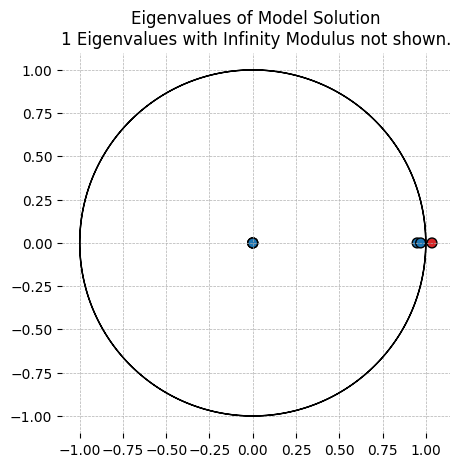

In [13]:
gp.plot_eigenvalues(rbc);

Our model is stable. Blanchard and Kahn (1980) established conditions for the uniqueness and existence of a solution to the model. Evaluated at the steady state, we have 2 eigenvalues greater than 1 in modulus (shown on the figure above).

We have two unstable eigenvalues for two forward-looking (state) variables, meaning our model is saddle path stable. 

If the number of eigenvalues with a modulus value greater than 1 (unstable root) is equal to the number of state variables, then there is a unique solution and the model is saddle path stable. If there are fewer unstable eigenvalues than state variables, there exist many paths back to the steady state following a shock. If there are more unstable eigenvalues, then the model is unstable and the model will eplode or implode with a shock (Costa, 2018).


In [14]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

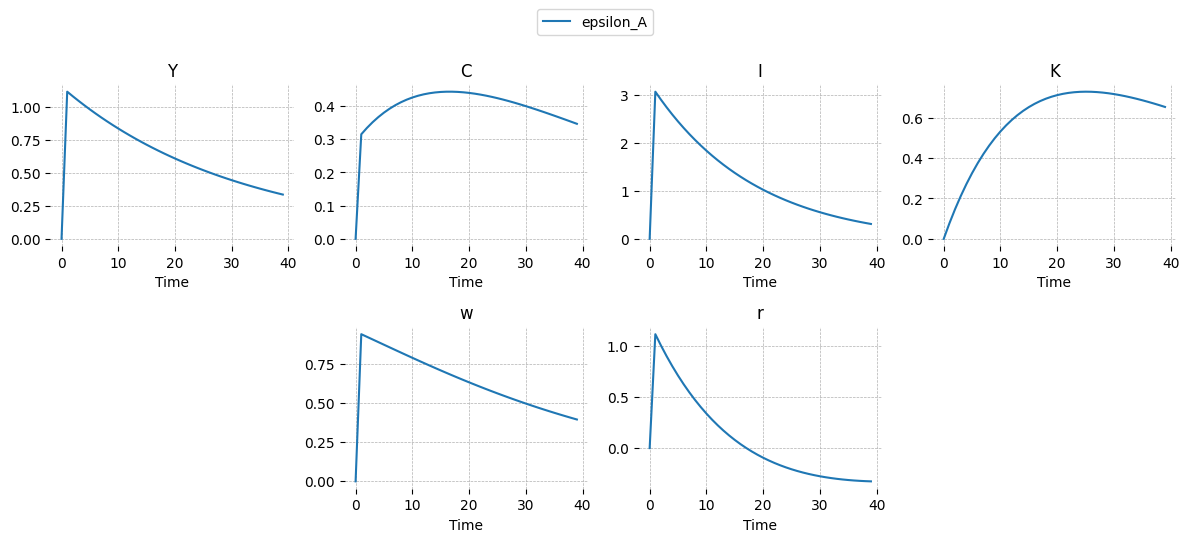

In [15]:
irf = rbc.impulse_response_function()
gp.plot_irf(irf, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
            n_cols=4, figsize=(12, 5), legend=True);

If we look at the Impulse response functions of the RBC model, there is an abrupt increase in output, investment, consumption, wage, and real interest rate when the shock is introduced, whereas capital increases non-linearly with diminishing marginal returns. In the long run, investment returns to the initial level, while the real interest rate falls below the initial level. Both wage and output tend to return to the initial levels with a lower slope than investment. Differently, consumption increases even more after the abrupt rise and decreases towards the first response level in the long run.

In [16]:
sigma = rbc.compute_stationary_covariance_matrix()
acorr_matrix = rbc.compute_autocorrelation_matrix(n_lags=30)


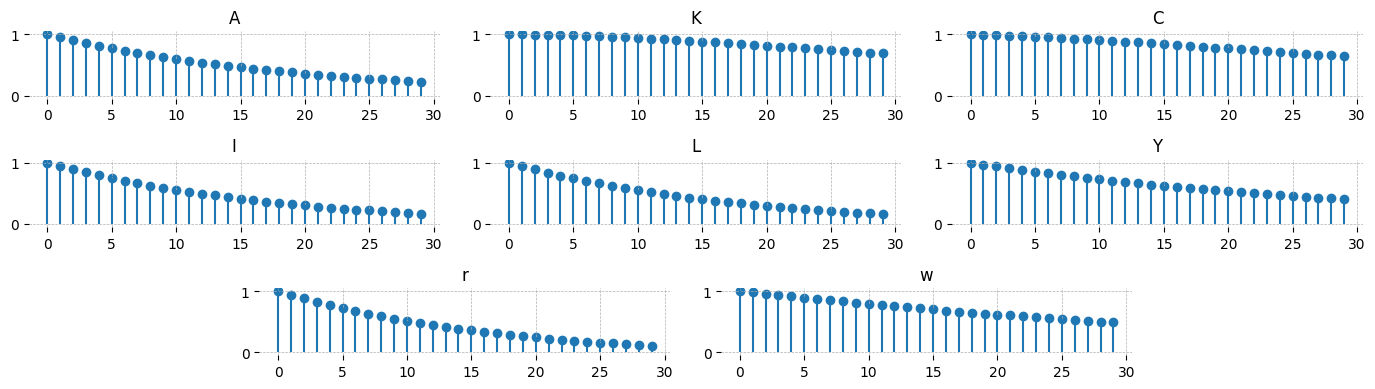

In [17]:
gp.plot_acf(acorr_matrix, vars_to_plot=['A', 'K', 'C', 'I', 'L', 'Y', 'r', 'w'], n_cols=3);

The figure above reflects the autocorrelative (or pesistence) of the variables in the model. A faster decline in the lines shows a lower degree of persistence in the variable value. In other words a steep slope, like with the rental rate of capital, means that the value of this rate today is less 'tied' with the value of 'r' yesterday. This is opposite to highly structural variables like K, C and Y. These variables often show smoothing patterns over time and are sensitive to their values in the previous period. For example, investment in capital is unlikely to be as sensitive to a change in the macroeconomic environment as the interest rate, for example, and is therefore more likely to be correlated with itself.

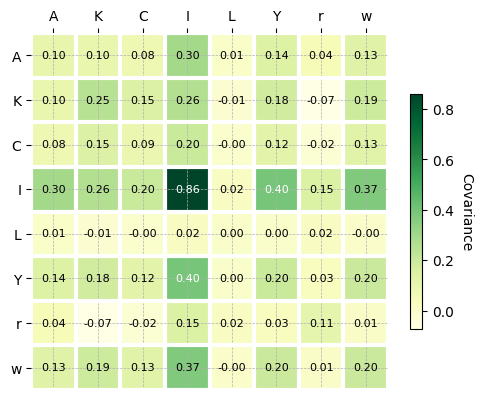

In [18]:
gp.plot_covariance_matrix(sigma, ['A', 'K', 'C', 'I', 'L', 'Y', 'r', 'w'],
                          figsize=(5,5),
                          cbar_kw=dict(shrink=0.5));

This figure shows a covariance matrix, showing how much two variables vary together. The diagonal (covariance of a varibale with itself) is simply the variance of a variable. We can see that the variance of investment instantly stands out at 0.86. Other variables display little (A, K, C, Y, r, w) or no variance (L). 

In [19]:
simulation = rbc.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=100)

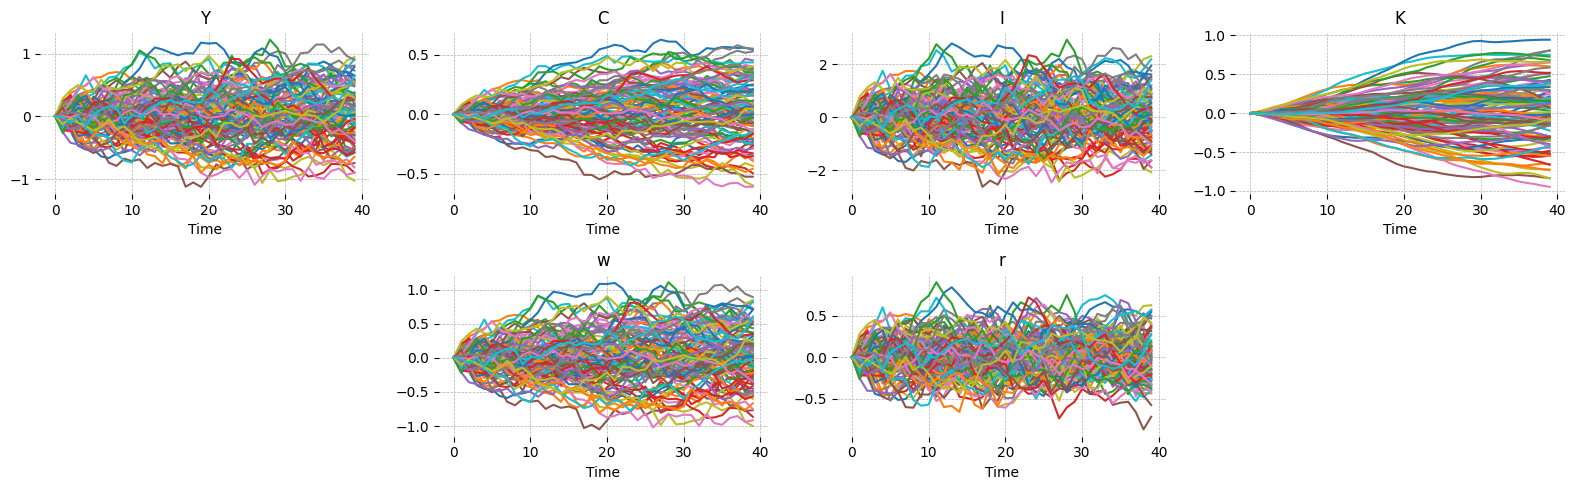

In [20]:
gp.plot_simulation(simulation, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
                   n_cols=4, figsize=(16, 5));


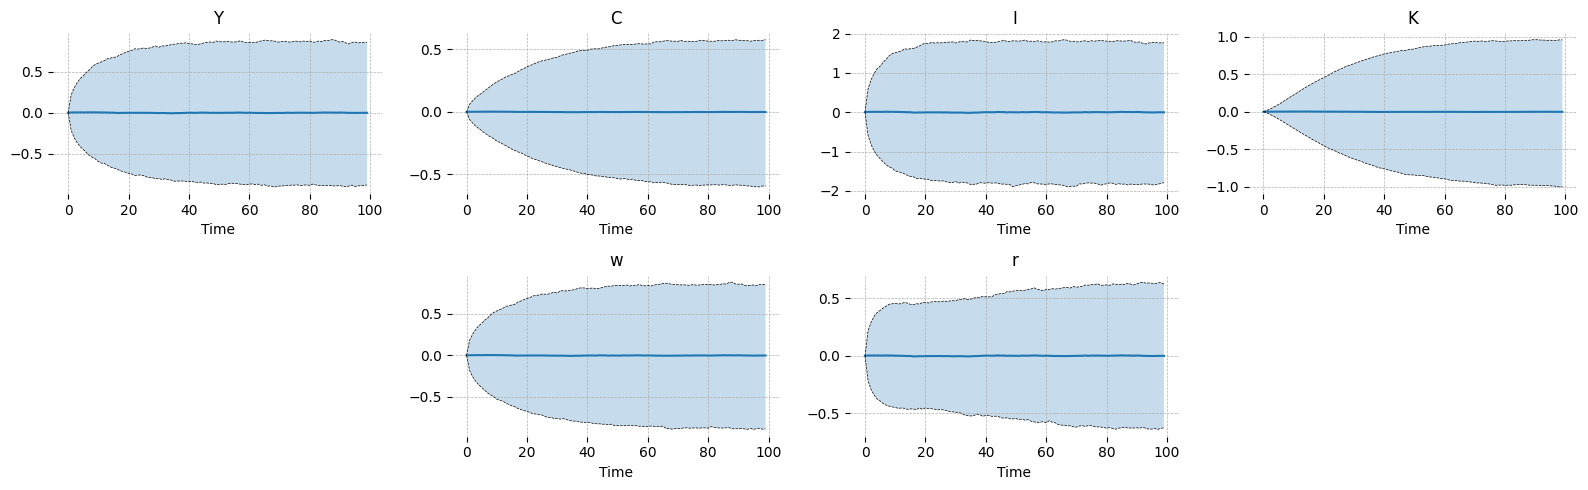

In [21]:
simulation = rbc.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=10_000, simulation_length=100)
gp.plot_simulation(simulation, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'], ci=0.95,
                   n_cols=4, figsize=(16, 5));

Following 100 simulations of the variables, this figure shows the area within which 95% of the simulations lie.

## Importing our data

In [22]:
data = df = pd.read_csv('/Users/joelthomas/Documents/RBC project/RBC_UK.csv', index_col=0, parse_dates=['DATE'], infer_datetime_format=True)

In [23]:
indicators = ['Consumption', # Consumption
              'Investment', # Investment
              'BOND', # real interest rate
              'GDP', # GDP
              'Labour', # Hours worked in a quarter
              'Wage' # average hourly wage
             ]

In [24]:
df.head()

Consumption    Investment      BOND   GDP  Labour  Wage
DATE                                                                
1960-01-01  4.266000e+09  1.073000e+09  0.054400  6424     NaN   NaN
1960-04-01  4.279000e+09  1.103000e+09  0.058000  6484     NaN   NaN
1960-07-01  4.308000e+09  1.148000e+09  0.060467  6578     NaN   NaN
1960-10-01  4.349000e+09  1.193000e+09  0.061367  6715     NaN   NaN
1961-01-01  4.453000e+09  1.239000e+09  0.060700  6882     NaN   NaN

In [25]:
data.describe()

Consumption    Investment        BOND            GDP        Labour  \
count  2.500000e+02  2.500000e+02  250.000000     250.000000    206.000000   
mean   1.337343e+11  3.732901e+10    0.070882  209469.476000  11726.391262   
std    1.173895e+11  3.126502e+10    0.039017  183464.631799    824.094175   
min    4.266000e+09  1.073000e+09    0.002514    6424.000000  10280.400000   
25%    1.843375e+10  6.106250e+09    0.045340   29669.250000  11191.050000   
50%    1.090660e+11  3.642900e+10    0.066600  174693.000000  11577.800000   
75%    2.376960e+11  6.256425e+10    0.099367  372293.250000  12105.600000   
max    3.863320e+11  1.069810e+11    0.160200  619570.000000  13687.700000   

            Wage  
count  90.000000  
mean   12.070262  
std     2.264397  
min     8.136524  
25%    10.374630  
50%    12.208650  
75%    13.246944  
max    17.319232

Regarding the descriptive statistics we got from our analysis, a summary of our model is presented above. In order to detect the distribution of the six variables in our model, we collected 250 quarterly data from the beginning of 1960 to the second quarter of 2022. For the wage variable, we collected 90 samples due to the availability of the data. As far as the central analysis is concerned, investment, interest rate, labour, and wage variables are distributed more symmetrically in contrast to consumption and output. The difference between the mean and 50th percentile is visibly higher in consumption and output making the distribution right skewed as the mean is greater than the median for both. The mean value is lesser than the median value only in the wage variable, so we can say that most of the data are located on the high side of the graph for this variable.

It is important to note that GDP is measured in millions of pounds, whereas consumption and investment are measured in just pounds.

In [26]:
df = data.resample('QS').last()
df = df.rename(columns=dict(zip(indicators, ['C', 'I', 'r', 'Y', 'L', 'w'])))
df.index.name = 'Time'

# Regular at least 3 observed series
df.dropna(thresh=3, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 1960-01-01 to 2022-04-01
Freq: QS-JAN
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C       250 non-null    float64
 1   I       250 non-null    float64
 2   r       250 non-null    float64
 3   Y       250 non-null    int64  
 4   L       206 non-null    float64
 5   w       90 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [28]:
def plot_df(df):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()

<AxesSubplot: xlabel='DATE'>

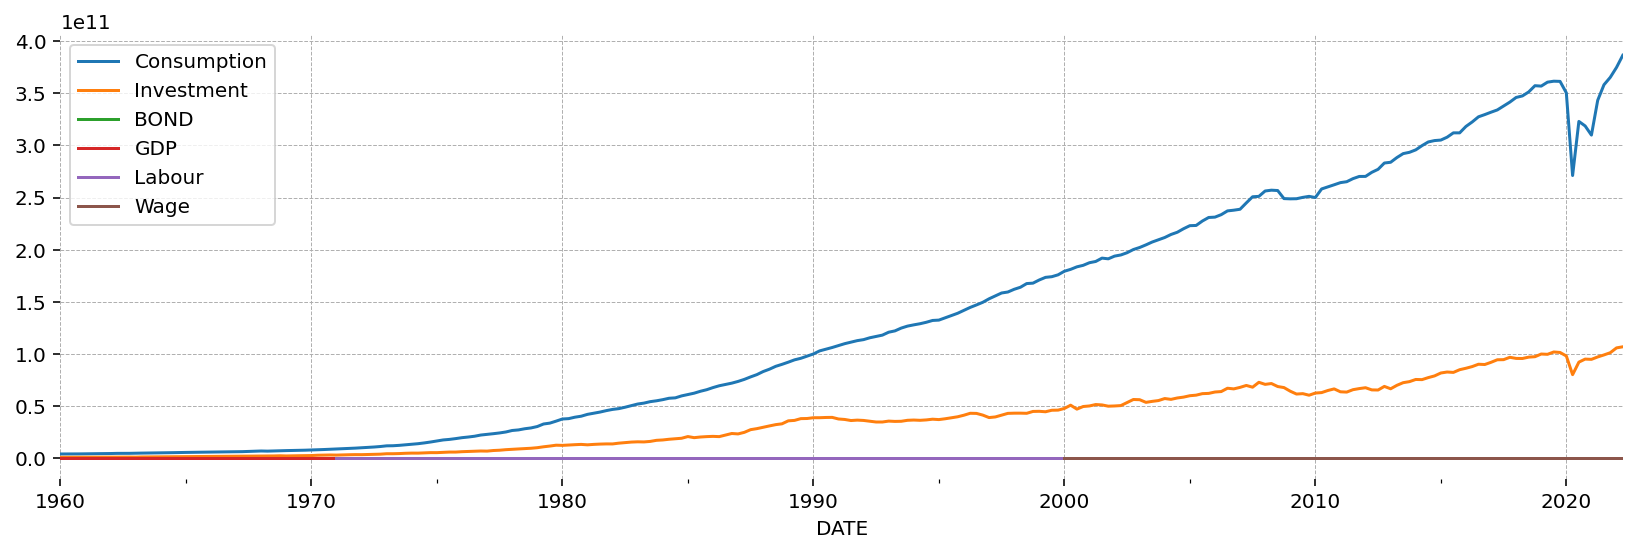

In [29]:
data.resample('QS').last().plot()

Here we can see the evolution of our variables over time. As exepected we can see an increasing trend over time. We can observe a hiccup around the 2008 mark with the global financial crisis. A more informative representation of the data is shown below.

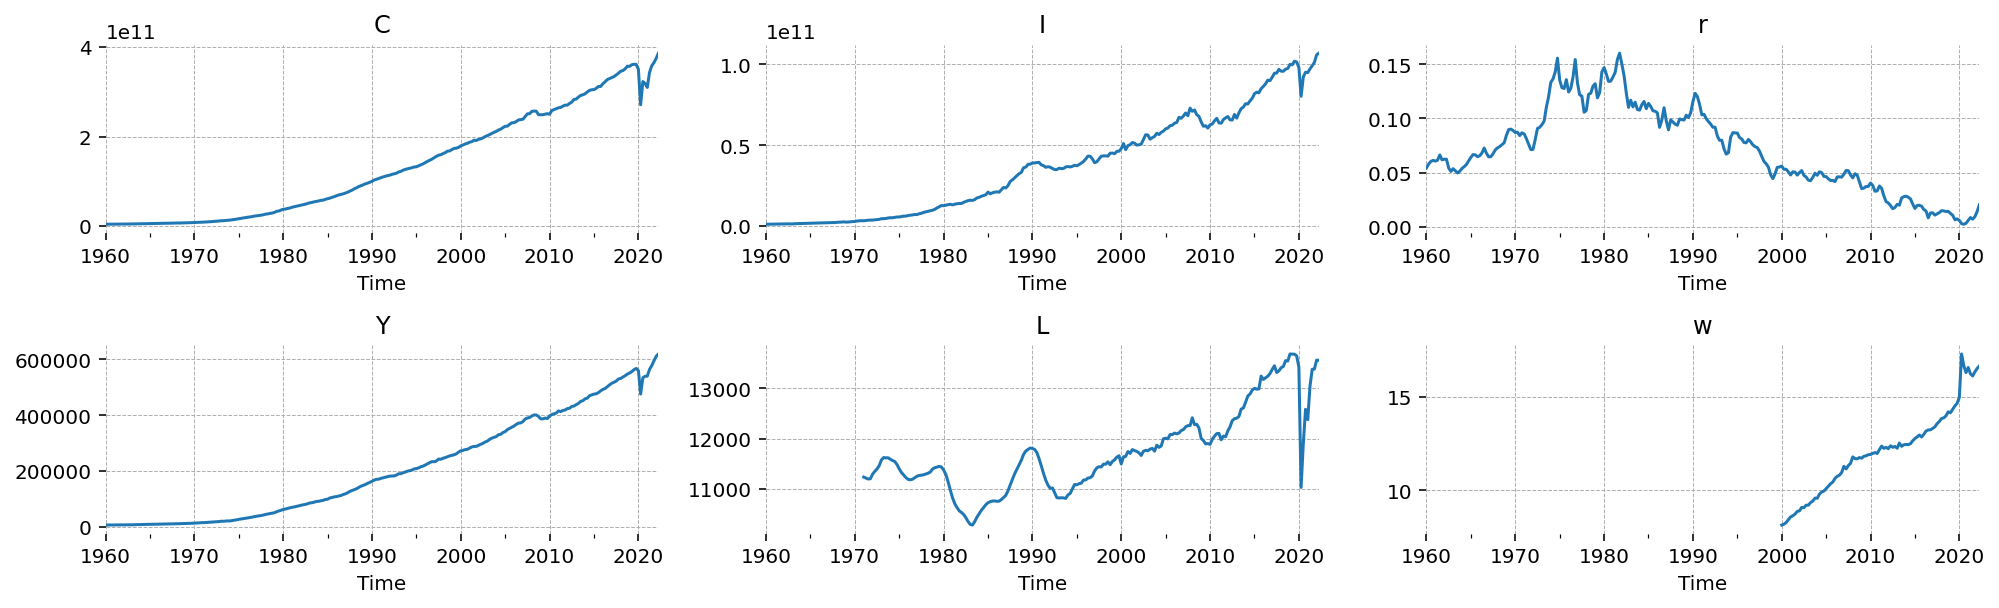

In [30]:
plot_df(df)

As said, there is a stutter in the consistent upward trend in 2008 in all but the interest rate (which appears to be stationary). However, the 2008 fall is much less severe than the drop in the first and second quarters of 2020 due to COVID.

Consumption, GDP, and investment all appear to be correlated and their trends look much the same as each other. This is to be expected given that GDP encompasses both consumption and investment.

Labour supply is much less stable. It is highly turbulent during the 1980s and early 1990s. This is likely to relfect, at least in part, the economic instability of the country in that period. Margaret Thatcher was elected as Prime Minister in 1979, lasting until 1990. There was a lot of economic unrest in the country around this time, with crippling strikes. Thatcher, like Reagan, subscribed to libertarian ideal of a small state and supply side economics. Her policies of mass privatisation, particularly of the mining industry in the North-East, crippled the labour supply. Strikes were regular and employment was unstable (see Darby & Lothian, 1983).

The other big movements in the labour supply can be seen in 2008, again because of the financial crisis, and in 2020. The UK government was responsible for a furlow scheme during the covid lockdowns, involving subsised wages to stay at home, hence the large drop in labour in 2020. Labour supply, nevertheless, does exhibit an upwards-ish trend. 

There is little to comment on wage. Given that data could only be collected from 2000 onwards, it is difficult to comment on the overarching intergenerational trends of wages in the UK but, judging only from what we see, they seem to be increasing as time goes on.



## Train-test split

Now we do the train-test split. We are removing the last 10% of the data to create a test environment after the simulation of our model.

In [31]:
#Compute 10% of the data
n_test = int(df.shape[0] * 0.1)
print(f'10% of the data is {n_test} observations')

# Use iloc to split. 
df_train = df.iloc[:-n_test, :]
df_test = df.iloc[-n_test:, :]

10% of the data is 25 observations


Let's plot the 90% of the data we haven't reserved for our forecast comparison.

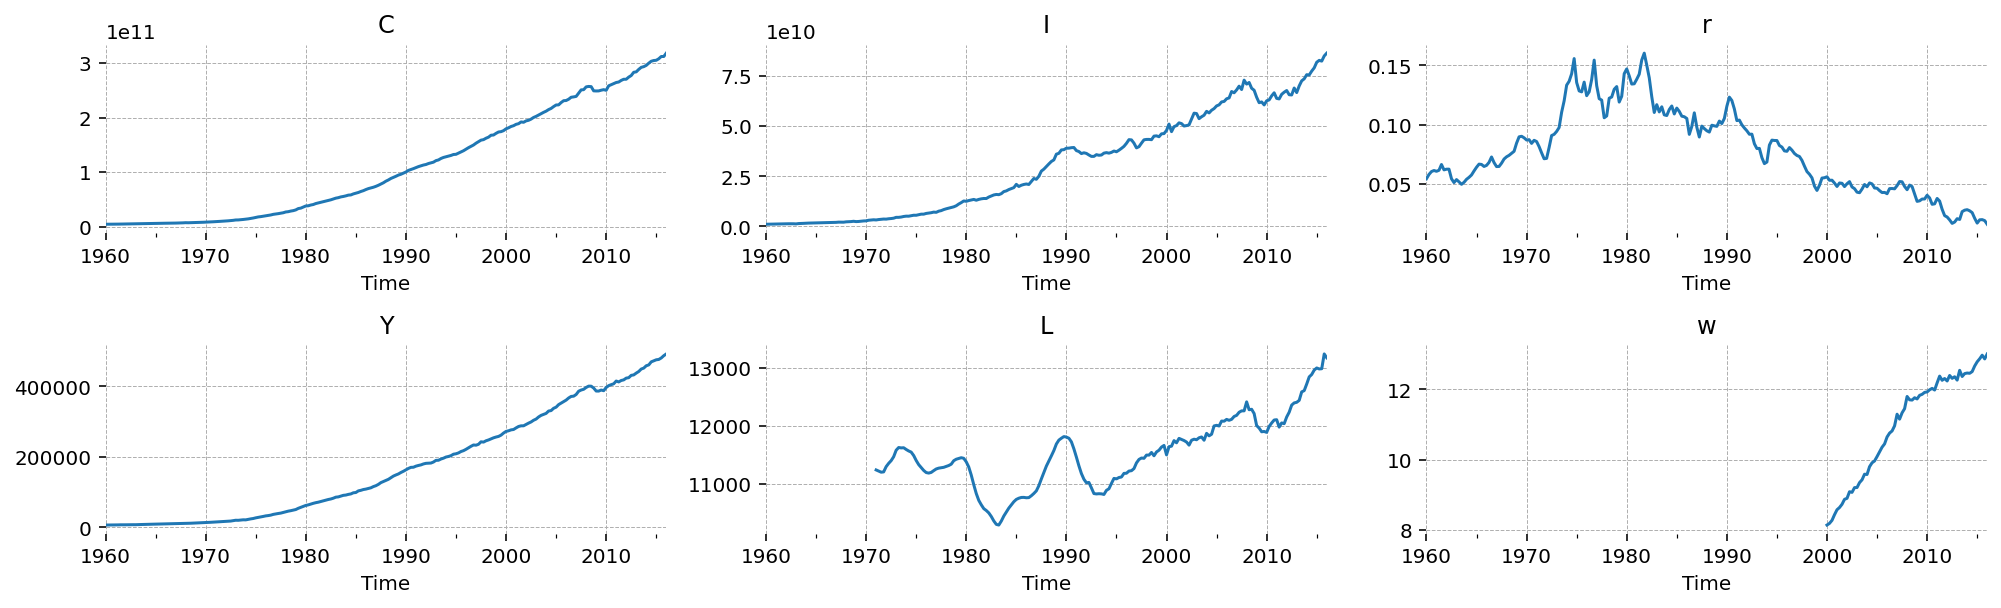

In [32]:
plot_df(df_train)

In [33]:
ADF_test_summary(df_train['r'])

                                                      r                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.022         -1.773        0.718          2    -4.000      -3.430     -3.139
	Constant             0.003          2.102        0.037
	Trend               -0.000         -2.284        0.023
Constant Only               -0.008         -0.686        0.850          2    -3.460      -2.875     -2.574
	Constant             0.000          0.428        0.669
No Constant                 -0.003         -0.731        0.399          2    -2.576      -1.942     -1.616


This is an augmented Dickey-Fuller test for stationarity of r.  In all cases we fail to reject the null hypothesis that there is a unit root: and it is therefore non-stationary.
However, looking at r it seems as if there is not really a trend; maybe slightly downwards, but nothing too substantial.


## Preprocessing

In [34]:
# Log and detrend everything that needs logging and detrending
# Make a design matrix. I will include a quadratic term based on the plots (they look like they have a 2nd
# derivative)
X = np.c_[np.ones(df.shape[0]), np.arange(df.shape[0]), np.arange(df.shape[0]) ** 2]

#split the design matrix into train/test as well
X_train = X[:-n_test, :]
X_test = X[-n_test:, :]


# Make a new df to hold my results
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()
for variable in ['Y', 'I', 'C', 'L', 'w']:
    log_train_var = np.log(df_train_processed[variable])
    log_test_var = np.log(df_test_processed[variable])
    
    #Make sure to drop the missing values, or else everything will come out as np.nan
    mod = sm.OLS(log_train_var, X_train, missing='drop')
    res = mod.fit()
    df_train_processed[variable] = res.resid
    
    #Use .predict to get the detrended test data (without showing the model the test data!)
    test_hat = res.predict(X_test)
    test_res = log_test_var - test_hat
    df_test_processed[variable] = test_res

# Here, we subtract the training mean from the test data
df_test_processed['r'] = (df_test_processed['r'] - df_train_processed['r'].mean())

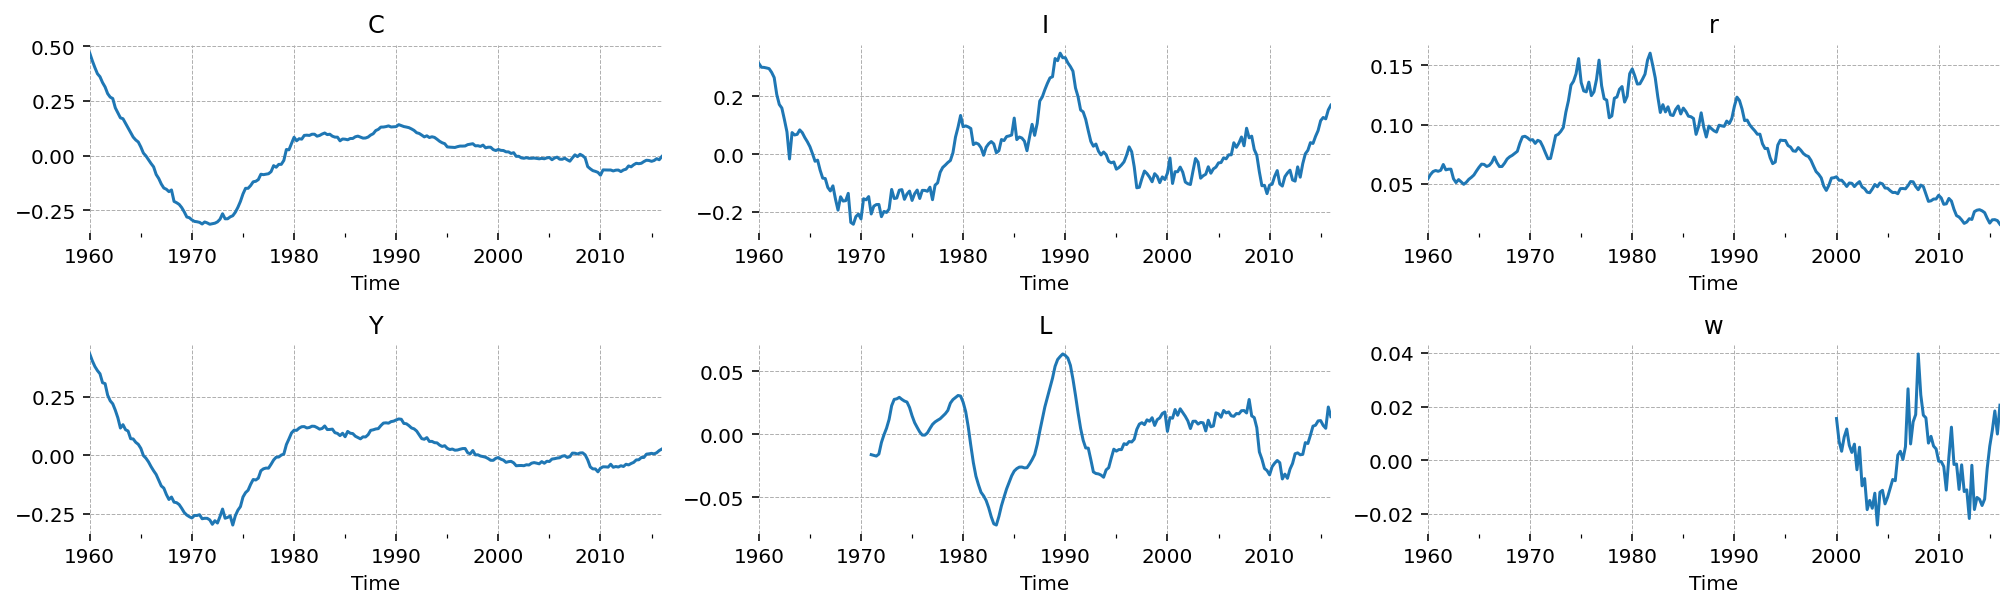

In [35]:
plot_df(df_train_processed)

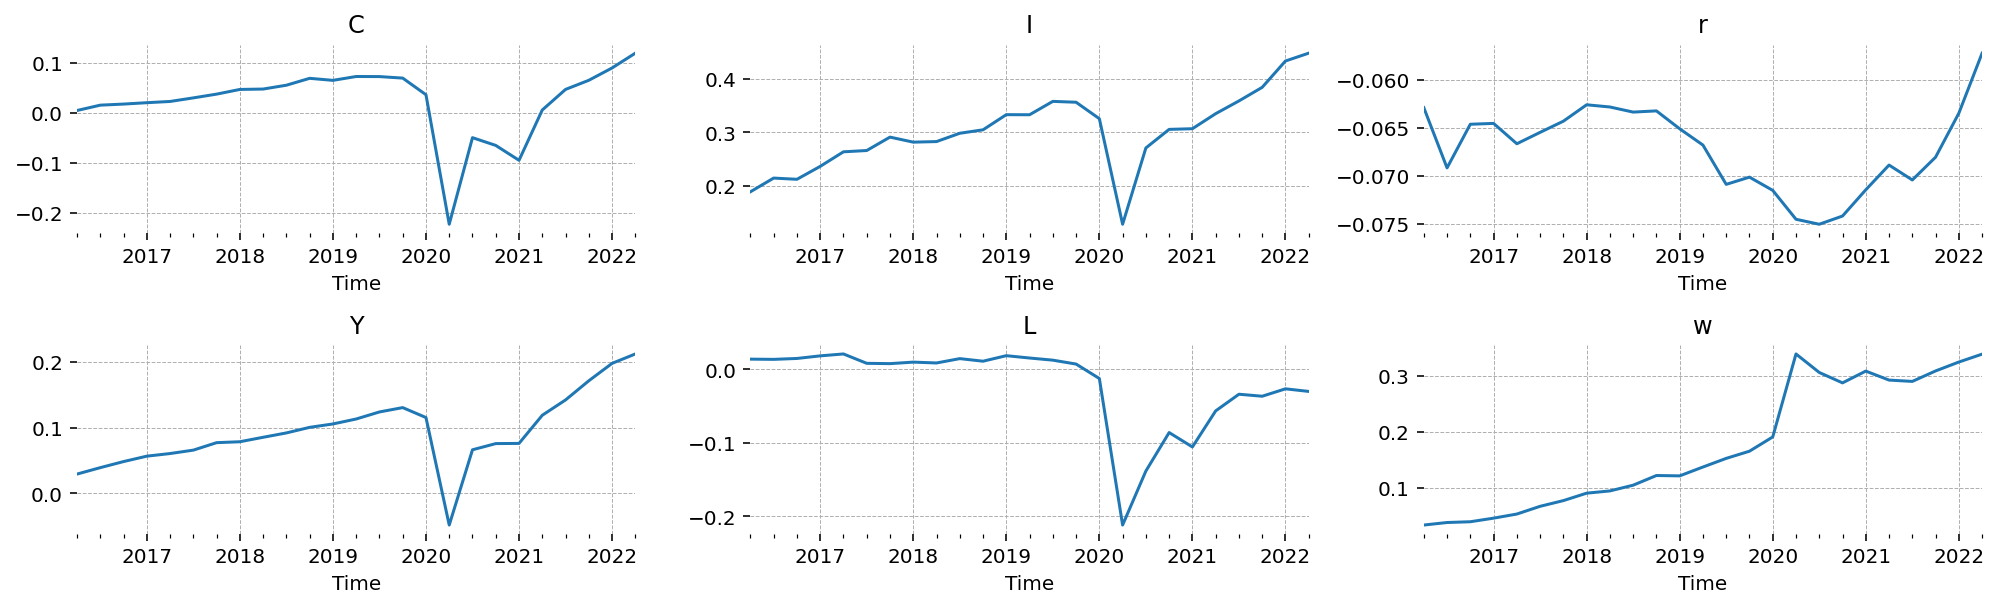

In [36]:
plot_df(df_test_processed)

In [37]:
ADF_test_summary(df_train_processed, missing='drop')

                                                      C                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.013         -2.549        0.304          3    -4.000      -3.431     -3.139
	Constant            -0.002         -1.349        0.179
	Trend                0.000          1.266        0.207
Constant Only               -0.012         -2.384        0.146          3    -3.460      -2.875     -2.574
	Constant            -0.000         -0.491        0.624
No Constant                 -0.012         -2.357        0.018          3    -2.576      -1.942     -1.616
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

Looking now at 'No Constant' because we have detrended AND subtracted the mean, we expect there to be no intercept. In all cases except with the interest rate, we can reject the null hypothesis that there is a unit root, and accept the alternative hypothesis that the processed data is stationary with 90% confidence.

Regarding the interest rate, visual examination suggests stationarity to an acceptable degree, so we will not live and die by the ADF test (this time).

## MLE Estimation/Predictions

In [38]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [39]:
from gEconpy.classes.transformers import PositiveTransformer, IntervalTransformer

# I only want to estimate rho_A, so I only put rho_A in the start_param_dict
param_start_dict = {'rho_A':0.95}

# Likewise, I want to estimate the shock on epsilon_A, so I put that in shock_start_dict
shock_start_dict = {
    'epsilon_A':0.05
}

# We will 100% trust the GDP data, so noise_start_dict is empty.
noise_start_dict = {}

# We want rho_A to be somewhere between 0 and 1, so we use an IntervalTransformer to restrict it.
# Don't actually pick 0 and 1, because you can get divide by zero errors. Instead pick numbers really close.
param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.9999)}


# Build the model!
mle_mod = MLEModel(df_train_processed[['Y']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [40]:
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -1.90322
basinhopping step 1: f -1.8872 trial_f -1.8872 accepted 1  lowest_f -1.90322
basinhopping step 2: f -1.87998 trial_f -1.87998 accepted 1  lowest_f -1.90322
basinhopping step 3: f -1.87998 trial_f -1.85739 accepted 0  lowest_f -1.90322
basinhopping step 4: f -1.50125 trial_f -1.50125 accepted 1  lowest_f -1.90322
basinhopping step 5: f -1.80084 trial_f -1.80084 accepted 1  lowest_f -1.90322
basinhopping step 6: f -1.88824 trial_f -1.88824 accepted 1  lowest_f -1.90322
basinhopping step 7: f -1.88608 trial_f -1.88608 accepted 1  lowest_f -1.90322
basinhopping step 8: f -1.56026 trial_f -1.56026 accepted 1  lowest_f -1.90322
basinhopping step 9: f -1.80922 trial_f -1.80922 accepted 1  lowest_f -1.90322
basinhopping step 10: f -1.78816 trial_f -1.78816 accepted 1  lowest_f -1.90322
basinhopping step 11: f -1.30007 trial_f -1.30007 accepted 1  lowest_f -1.90322
basinhopping step 12: f -1.35634 trial_f -1.35634 accepted 1  lowest_f -1.90322
basinhopping step 1

In [41]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  225
Model:                      DSGEModel   Log Likelihood                 165.416
Date:                Tue, 03 Jan 2023   AIC                           -326.831
Time:                        10:15:49   BIC                           -319.999
Sample:                    01-01-1960   HQIC                          -324.074
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9500      0.127      7.491      0.000       0.701       1.199
sigma2.epsilon_A     0.0289      0.009      3.313      0.001       0.012       0.046
===================================================================================
Ljung-Box (L1) (Q):                  10.08   Jarque-Bera (JB):              1070.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

## MLE Kalman Predictions

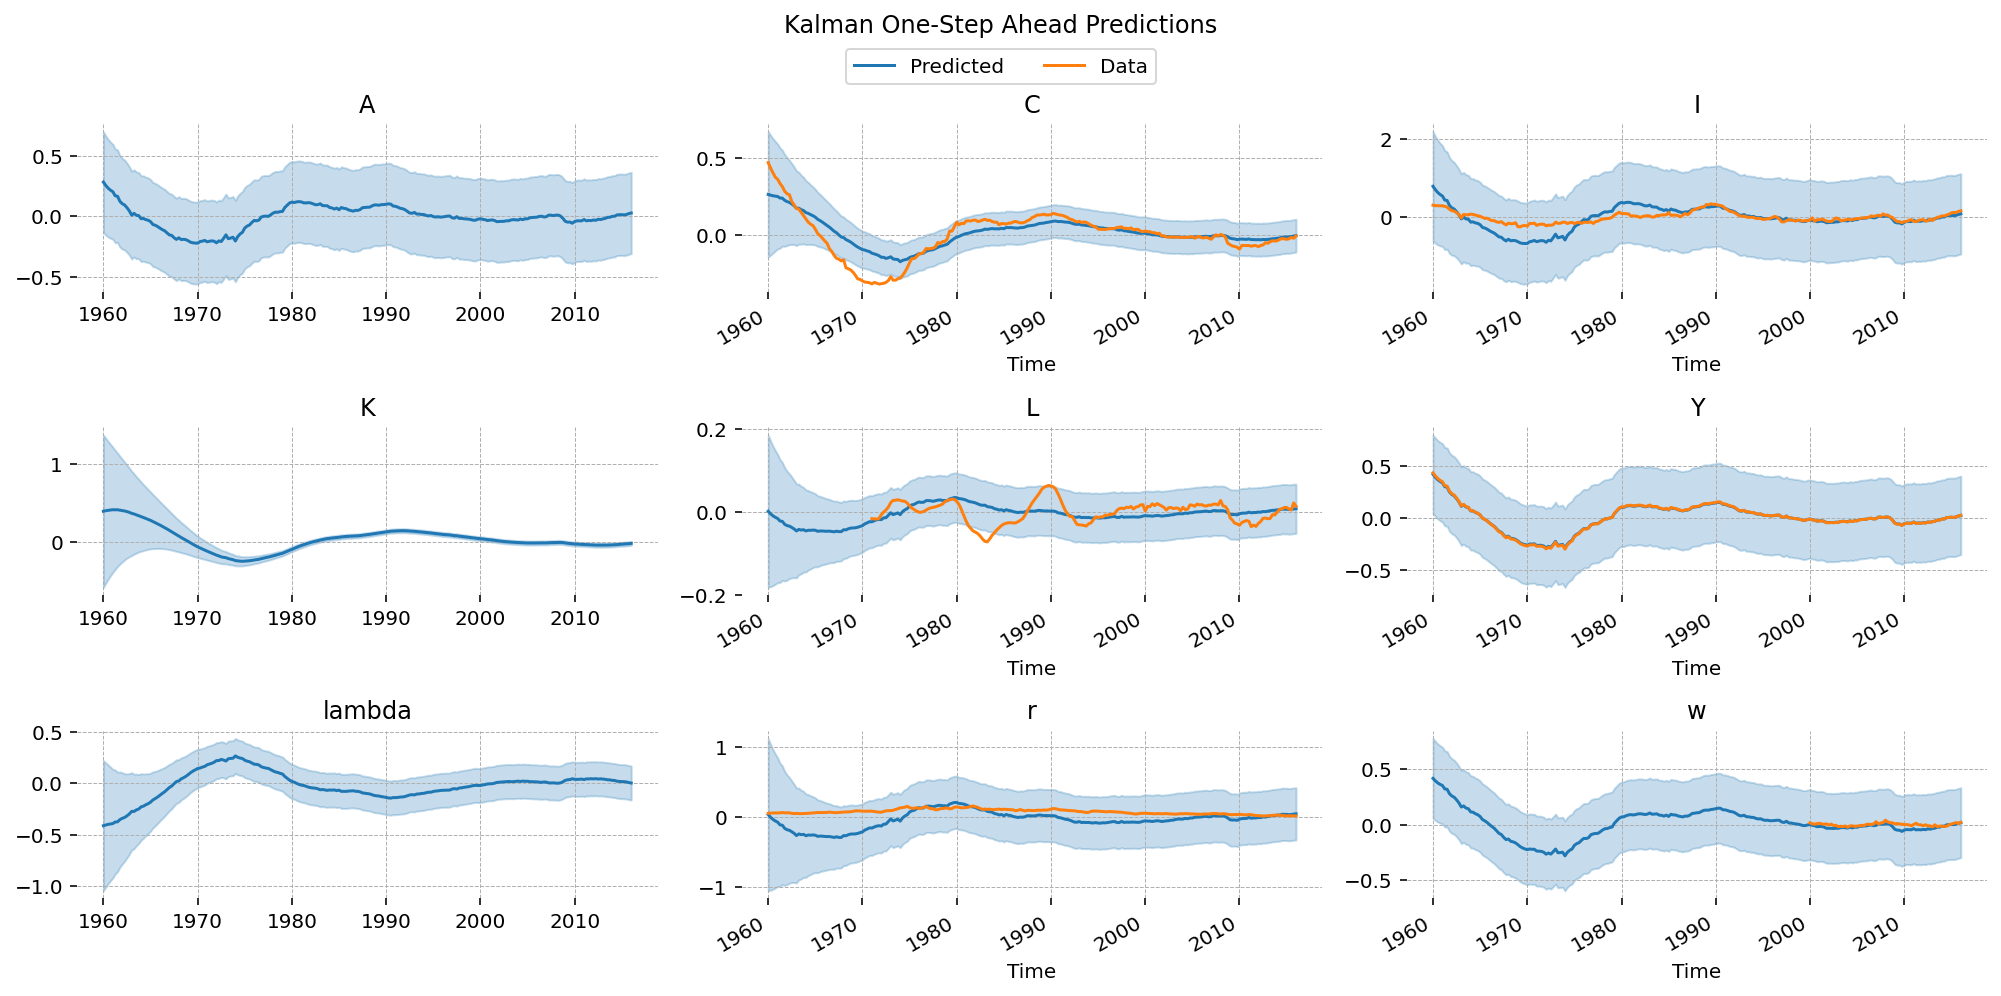

In [42]:
plot_sm_results(mle_res, df_train_processed, var_names=vars_to_plot)

Predicts well. Is bad at predicting L, especially around the 1990s. The model fails to reflect the volatility for r: it just hovers around a 0 mean. But, at least r is inside the 95% confidence interval. L is also quite bad. There is some undershoot around the 1990s, and the model fails to predict the 'dip' in the early 1980s and the 'peak' in the late 1980s, but overall it is not too bad. It predicts the general trend of labour but is not precise enough to predict the volatility.

Nevertheless, the data better matches the predicted values of L after the mid 1990s. L becomes much less volatile, perhaps this is following Thatcher's privatisation movement during the 1980s, which created labour market instability as we saw earlier. Because the prediction for labour supply was so poor, we will add L to the model next.

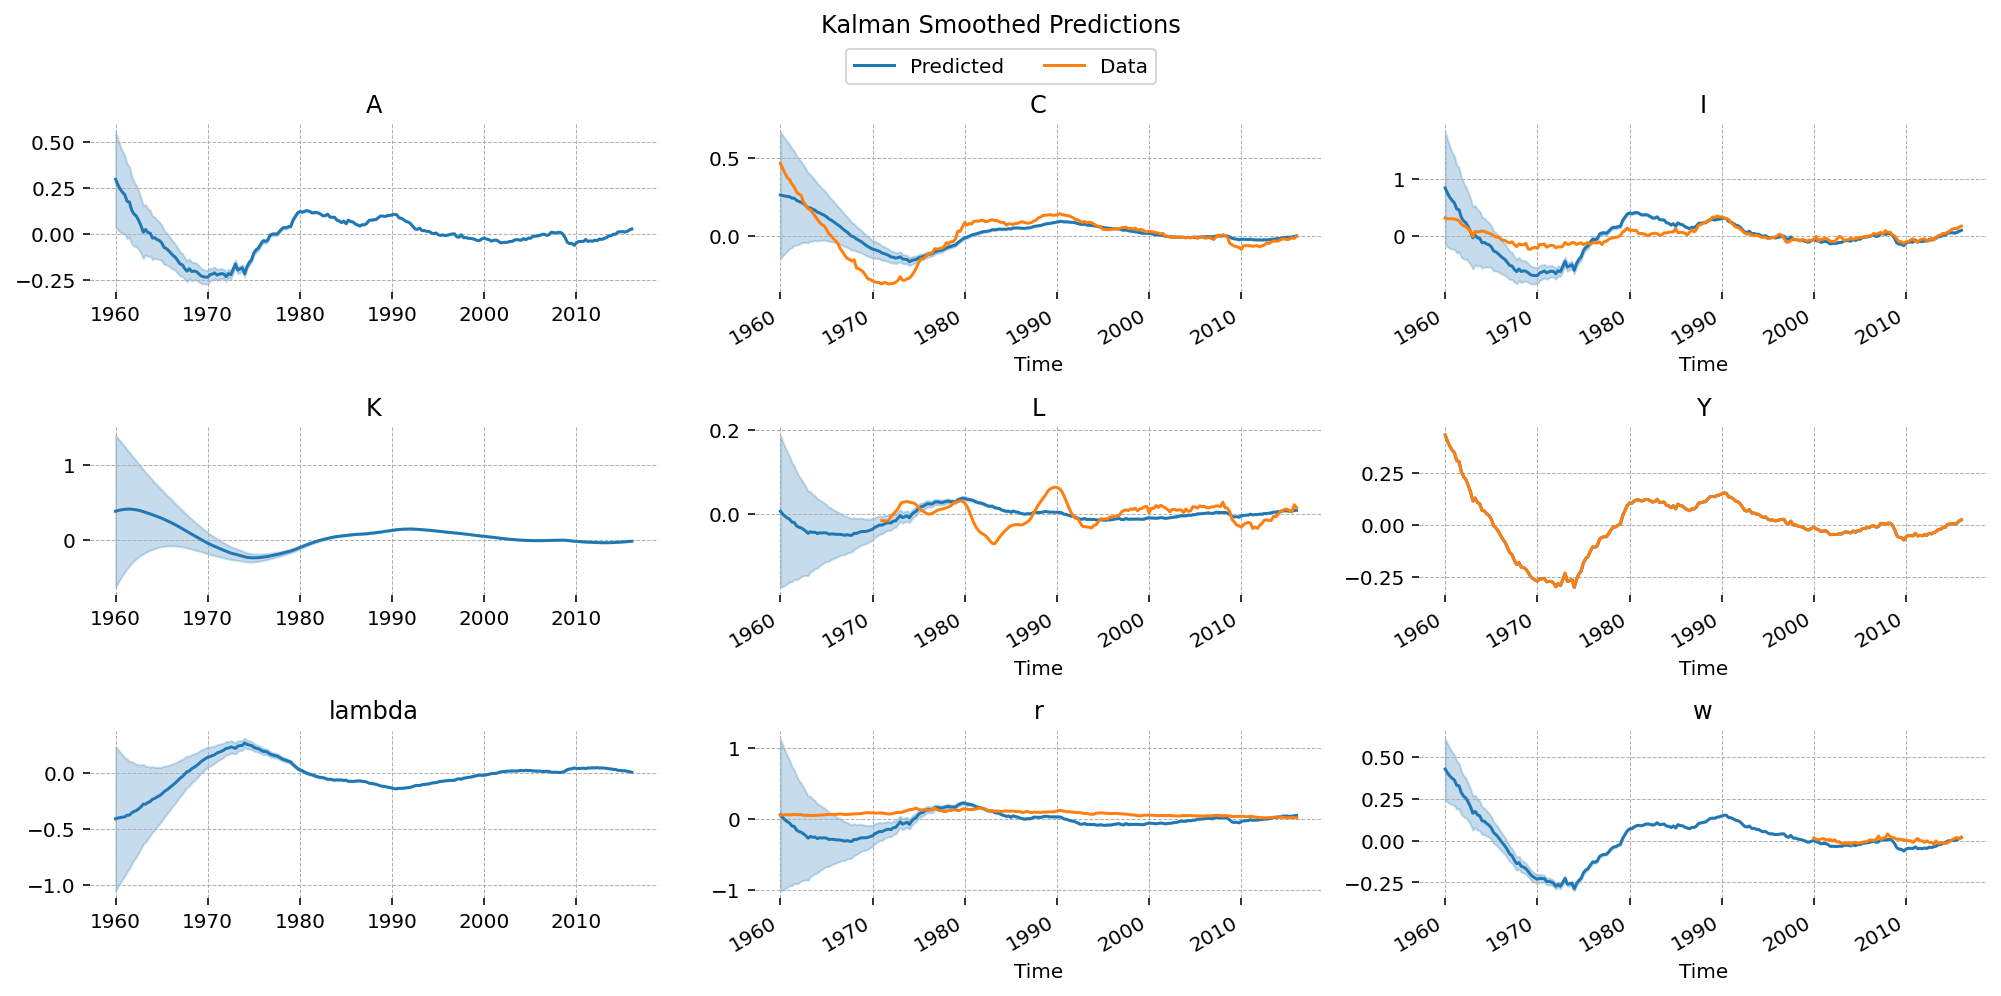

In [43]:
plot_sm_results(mle_res, df_train_processed, 'smoothed', var_names=vars_to_plot)

## Forecasting

In [44]:
mle_forecast = mle_res.get_forecast(steps=n_test)

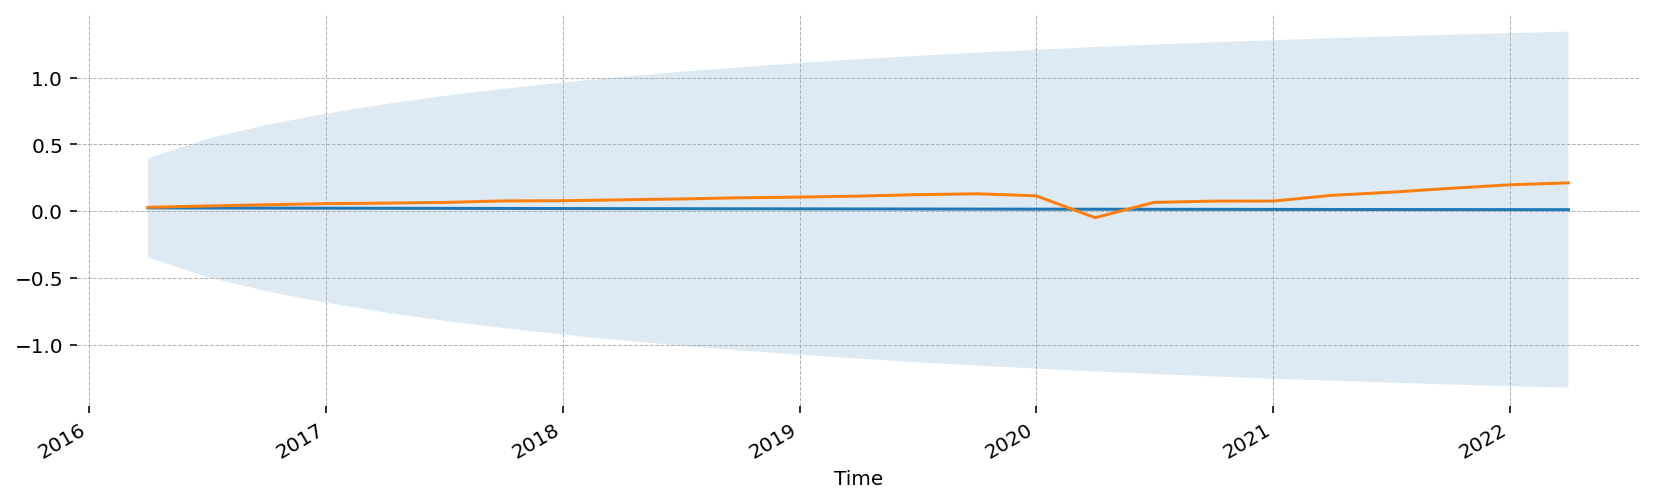

In [45]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
df_test_processed.Y.plot(ax=ax)
plt.show()

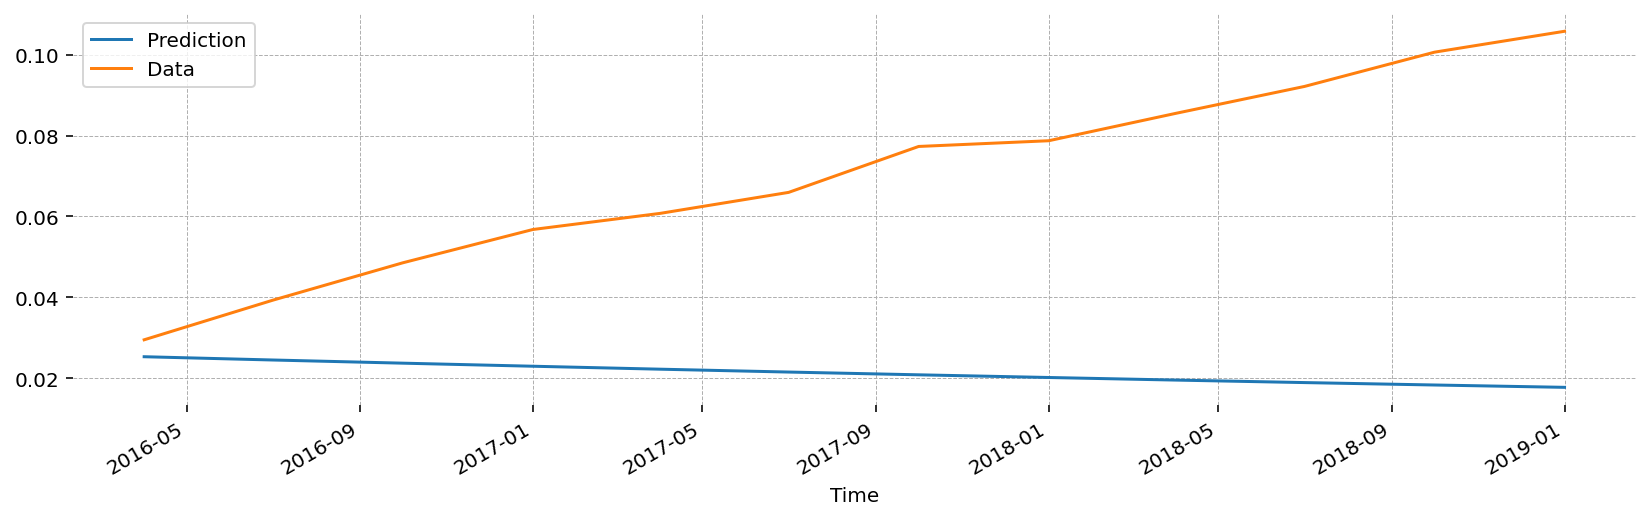

In [46]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
df_test_processed.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model's prediction is not good, but not terrible. Sometimes, the most you can expect from the RBC is to predict a variables movement in the right direction (increase or decrease), so at least we got that right. 

### Adding Observation Noise

In [47]:
param_start_dict = {'rho_A':0.95}
shock_start_dict = {'epsilon_A':0.05}

# Let's say that maybe GDP data is incorrect by up to 2%
noise_start_dict = {'Y':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.99)}

# Build the model!
mle_noise_mod = MLEModel(df_train_processed[['Y']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [48]:
mle_res_noise = mle_noise_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -1.8718
basinhopping step 1: f -1.82603 trial_f -1.82603 accepted 1  lowest_f -1.8718
basinhopping step 2: f -1.82603 trial_f -0.512098 accepted 0  lowest_f -1.8718
basinhopping step 3: f -1.75938 trial_f -1.75938 accepted 1  lowest_f -1.8718
basinhopping step 4: f -1.87277 trial_f -1.87277 accepted 1  lowest_f -1.87277
found new global minimum on step 4 with function value -1.87277
basinhopping step 5: f -1.8312 trial_f -1.8312 accepted 1  lowest_f -1.87277
basinhopping step 6: f -1.87071 trial_f -1.87071 accepted 1  lowest_f -1.87277
basinhopping step 7: f -1.87071 trial_f -1.11304 accepted 0  lowest_f -1.87277
basinhopping step 8: f -1.8339 trial_f -1.8339 accepted 1  lowest_f -1.87277
basinhopping step 9: f -1.81501 trial_f -1.81501 accepted 1  lowest_f -1.87277
basinhopping step 10: f -1.57138 trial_f -1.57138 accepted 1  lowest_f -1.87277
basinhopping step 11: f -1.76269 trial_f -1.76269 accepted 1  lowest_f -1.87277
basinhopping step 12: f -1.73809 trial_f

In [49]:
mle_res_noise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  225
Model:                      DSGEModel   Log Likelihood                 154.466
Date:                Tue, 03 Jan 2023   AIC                           -302.931
Time:                        10:17:49   BIC                           -292.683
Sample:                    01-01-1960   HQIC                          -298.795
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9697      0.512      1.895      0.058      -0.033       1.973
sigma2.epsilon_A     0.0304      0.522      0.058      0.954      -0.993       1.054
sigma2.Y             0.0020      0.362      0.005      0.996      -0.707       0.711
===================================================================================
Ljung-Box (L1) (Q):                  13.12   Jarque-Bera (JB):               264.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### Adding L to the model

Also using the lazy method to fix stochastic singularity.

In [50]:
# We want to estimate sigma_C as well now, so add it to the param_start_dict
param_start_dict = {'rho_A':0.95,
                    'sigma_C':1.5651}
                    
shock_start_dict = {'epsilon_A':0.05}

# Distrust labor data to fix the stochastic singularity
noise_start_dict = {'L':0.05}

# sigma_C should be bigger than 1, but other than that we don't care what it is.
param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.9999),
                    'sigma_C':IntervalTransformer(low=1.1, high=10.0)}

# Build the model!
two_var_mod = MLEModel(df_train_processed[['Y', 'L']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [51]:
two_var_res = two_var_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -3.03968
basinhopping step 1: f -2.7641 trial_f -2.7641 accepted 1  lowest_f -3.03968
basinhopping step 2: f -1.60951 trial_f -1.60951 accepted 1  lowest_f -3.03968
basinhopping step 3: f -1.06209 trial_f -1.06209 accepted 1  lowest_f -3.03968
basinhopping step 4: f -2.92274 trial_f -2.92274 accepted 1  lowest_f -3.03968
basinhopping step 5: f -3.05139 trial_f -3.05139 accepted 1  lowest_f -3.05139
found new global minimum on step 5 with function value -3.05139
basinhopping step 6: f -3.05139 trial_f -2.12441 accepted 0  lowest_f -3.05139
basinhopping step 7: f -3.05139 trial_f -1.95559 accepted 0  lowest_f -3.05139
basinhopping step 8: f -2.87277 trial_f -2.87277 accepted 1  lowest_f -3.05139
basinhopping step 9: f -2.87277 trial_f -0.628369 accepted 0  lowest_f -3.05139
basinhopping step 10: f -2.87277 trial_f -1.09149 accepted 0  lowest_f -3.05139
basinhopping step 11: f -2.87277 trial_f -2.27287 accepted 0  lowest_f -3.05139
basinhopping step 12: f -2.87277 t

In [52]:
two_var_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'L']   No. Observations:                  225
Model:                      DSGEModel   Log Likelihood                 283.521
Date:                Tue, 03 Jan 2023   AIC                           -559.043
Time:                        10:21:18   BIC                           -545.378
Sample:                    01-01-1960   HQIC                          -553.528
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9965      0.007    136.750      0.000       0.982       1.011
sigma_C              1.6443      4.345      0.378      0.705      -6.873      10.161
sigma2.epsilon_A     0.0340      0.048      0.708      0.479      -0.060       0.128
sigma2.L             0.0470      0.016      2.886      0.004       0.015       0.079
===================================================================================
Ljung-Box (L1) (Q):          13.82, 215.77   Jarque-Bera (JB):         18.09, 39.67
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.17, 3.92   Skew:                      -0.07, 0.38
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   4.38, 4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

ρA is pretty much the same as our starting value.

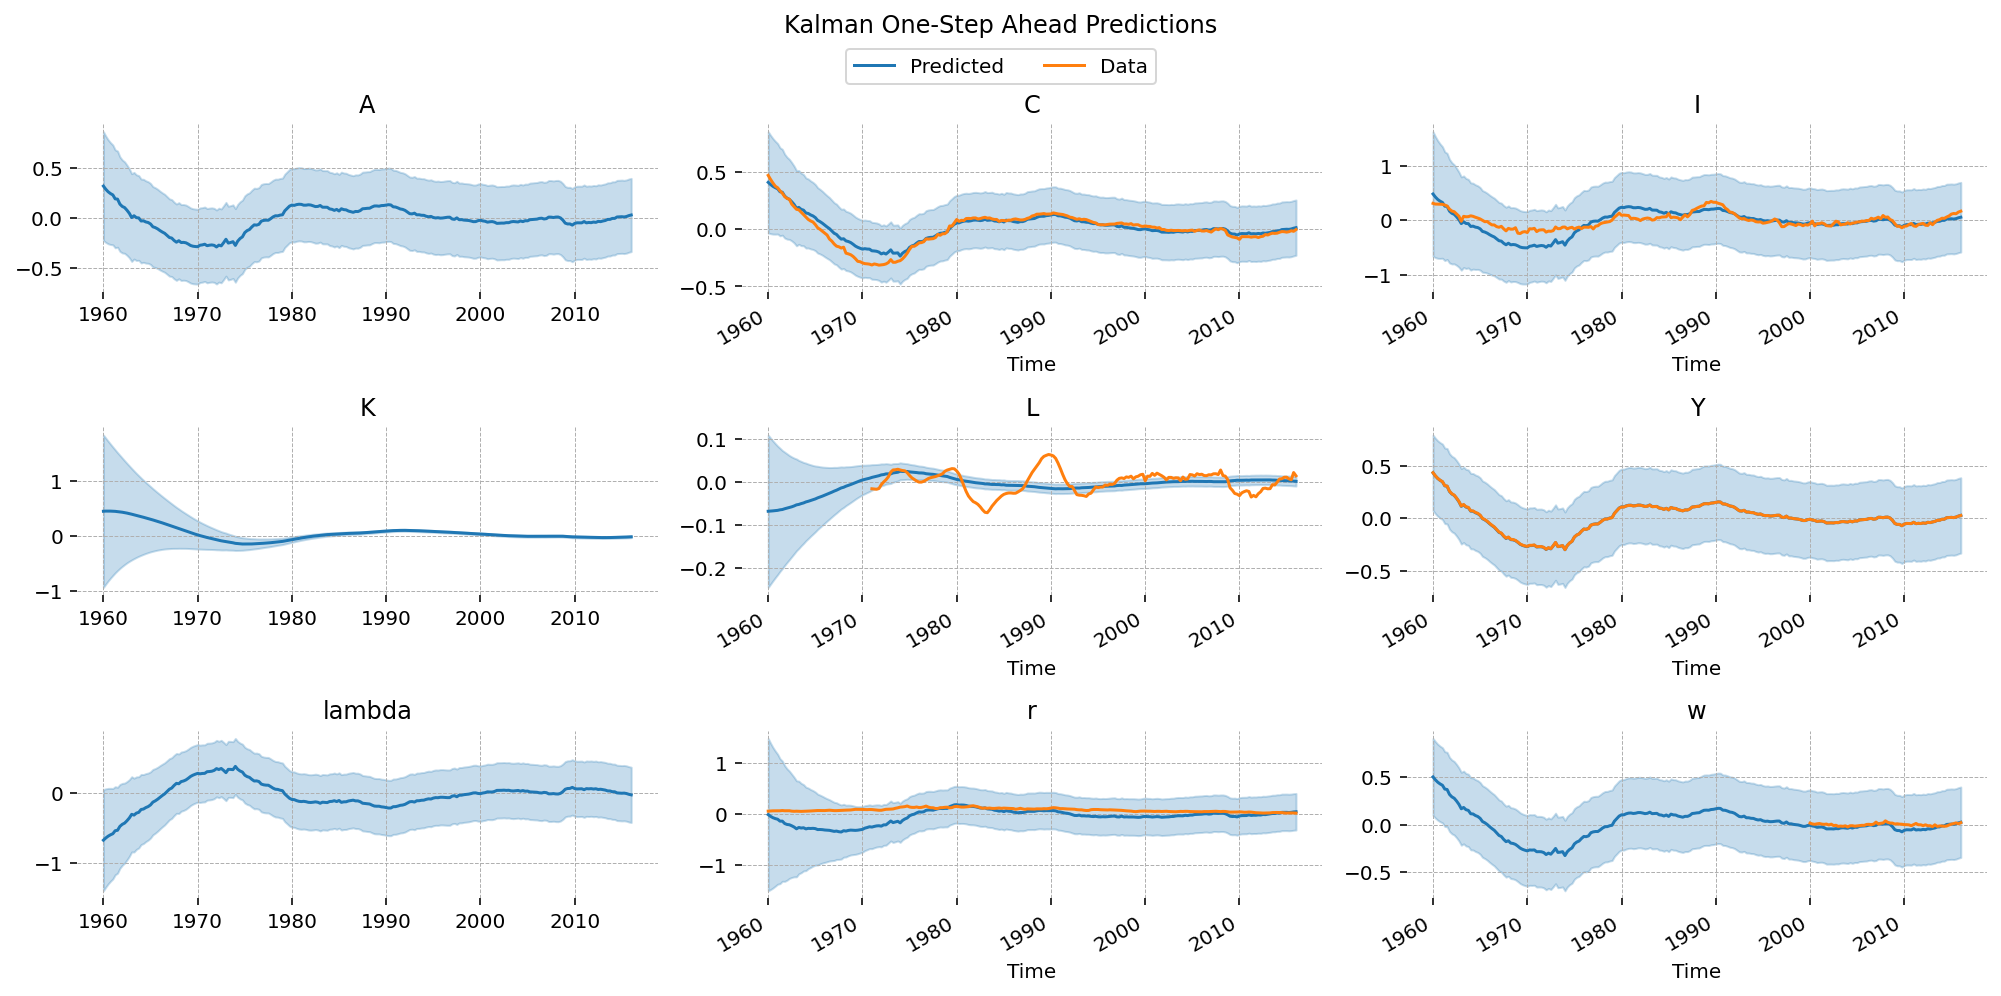

In [53]:
plot_sm_results(two_var_res, df_train_processed, var_names=vars_to_plot)

L is almost encompassed by the 95% confidence interval. This is a much better estimation than before. Again, the volatility of L is not captured by the model but the mean seems to be correct and the predicted and actual data coverge towards the end.

The prediction for consumption is also good. The data is not captured by the 95% confidence interval in the end of the 1970s, where there is a significant fall in consumption, but overall the model did a good job. Again, wage investment and rental rate of capital are all enveloped by the 95% confidence interval.

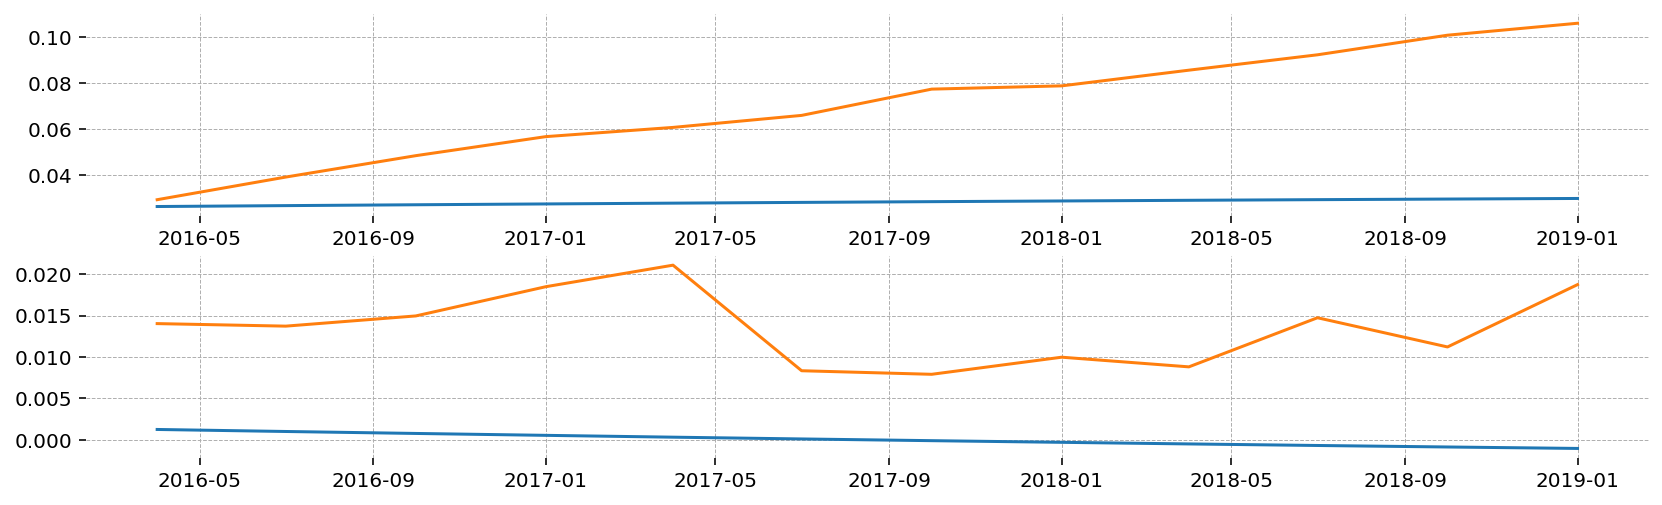

In [54]:
two_var_forecast = two_var_res.get_forecast(steps=n_test)
mu = two_var_forecast.predicted_mean

n_quarters = 12

fig, ax = plt.subplots(2, 1)
ax[0].plot(mu['Y'].iloc[:n_quarters])
ax[0].plot(df_test_processed.Y.iloc[:n_quarters])

ax[1].plot(mu['L'].iloc[:n_quarters])
ax[1].plot(df_test_processed.L.iloc[:n_quarters])

After increasing the noise and adding L as a dependent variable, ρA is approximately the same as our former value. However, it seems that we have Y and L decreasing, which is not reflected in the data.

## Adding wage to the model

In [55]:
# We want to estimate sigma_C as well now, so add it to the param_start_dict
param_start_dict = {'rho_A':0.95,
                    'sigma_C':1.5651,
                    'sigma_L':2.5147,
                    'alpha':0.35}

shock_start_dict = {'epsilon_A':0.05}

# Distrust labor and wage data to fix the stochastic singularity
# Let's start by distrusting wages a lot more than labor, since wages are a very noisy dataset with tons
# of missing values.
noise_start_dict = {'L':0.05,
                    'w':0.10}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=1.1, high=5.0),
                    'sigma_L':IntervalTransformer(low=1.1, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5)}

# Build the model!
three_var_mod = MLEModel(df_train_processed[['Y', 'L', 'w']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [56]:

three_var_res = three_var_mod.fit(method='basinhopping', stepsize=0.25, minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -3.83541
basinhopping step 1: f -3.83541 trial_f -2.03123 accepted 0  lowest_f -3.83541
basinhopping step 2: f -3.44083 trial_f -3.44083 accepted 1  lowest_f -3.83541
basinhopping step 3: f -3.44083 trial_f 51.1871 accepted 0  lowest_f -3.83541
basinhopping step 4: f -3.52333 trial_f -3.52333 accepted 1  lowest_f -3.83541
basinhopping step 5: f -3.29986 trial_f -3.29986 accepted 1  lowest_f -3.83541
basinhopping step 6: f -2.78583 trial_f -2.78583 accepted 1  lowest_f -3.83541
basinhopping step 7: f -2.81251 trial_f -2.81251 accepted 1  lowest_f -3.83541
basinhopping step 8: f -2.81251 trial_f -1.50764 accepted 0  lowest_f -3.83541
basinhopping step 9: f -3.52264 trial_f -3.52264 accepted 1  lowest_f -3.83541
basinhopping step 10: f -3.85232 trial_f -3.85232 accepted 1  lowest_f -3.85232
found new global minimum on step 10 with function value -3.85232
basinhopping step 11: f -3.85232 trial_f 0.302203 accepted 0  lowest_f -3.85232
basinhopping step 12: f -3.85232 

In [57]:
three_var_res.summary()

/opt/miniconda3/envs/econ/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        ['Y', 'L', 'w']   No. Observations:                  225
Model:                      DSGEModel   Log Likelihood                 352.215
Date:                Tue, 03 Jan 2023   AIC                           -690.430
Time:                        10:22:57   BIC                           -666.518
Sample:                    01-01-1960   HQIC                          -680.779
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9601      0.747      1.286      0.198      -0.503       2.423
sigma_C              2.1277     41.550      0.051      0.959     -79.309      83.564
sigma_L              2.9920     63.907      0.047      0.963    -122.263     128.247
alpha                0.4347     10.665      0.041      0.967     -20.468      21.337
sigma2.epsilon_A     0.0346      0.118      0.294      0.769      -0.196       0.265
sigma2.L             0.0332      0.013      2.530      0.011       0.007       0.059
sigma2.w             0.0278      0.011      2.539      0.011       0.006       0.049
=========================================================================================
Ljung-Box (L1) (Q):     10.75, 218.86, 187.57   Jarque-Bera (JB):   293.02, 30.56, 428.89
Prob(Q):                     0.00, 0.00, 0.00   Prob(JB):                0.00, 0.00, 0.00
Heteroskedasticity (H):       0.13, 3.18, inf   Skew:                   0.65, -0.49, 2.34
Prob(H) (two-sided):         0.00, 0.00, 0.00   Kurtosis:                8.44, 4.52, 7.88
=========================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

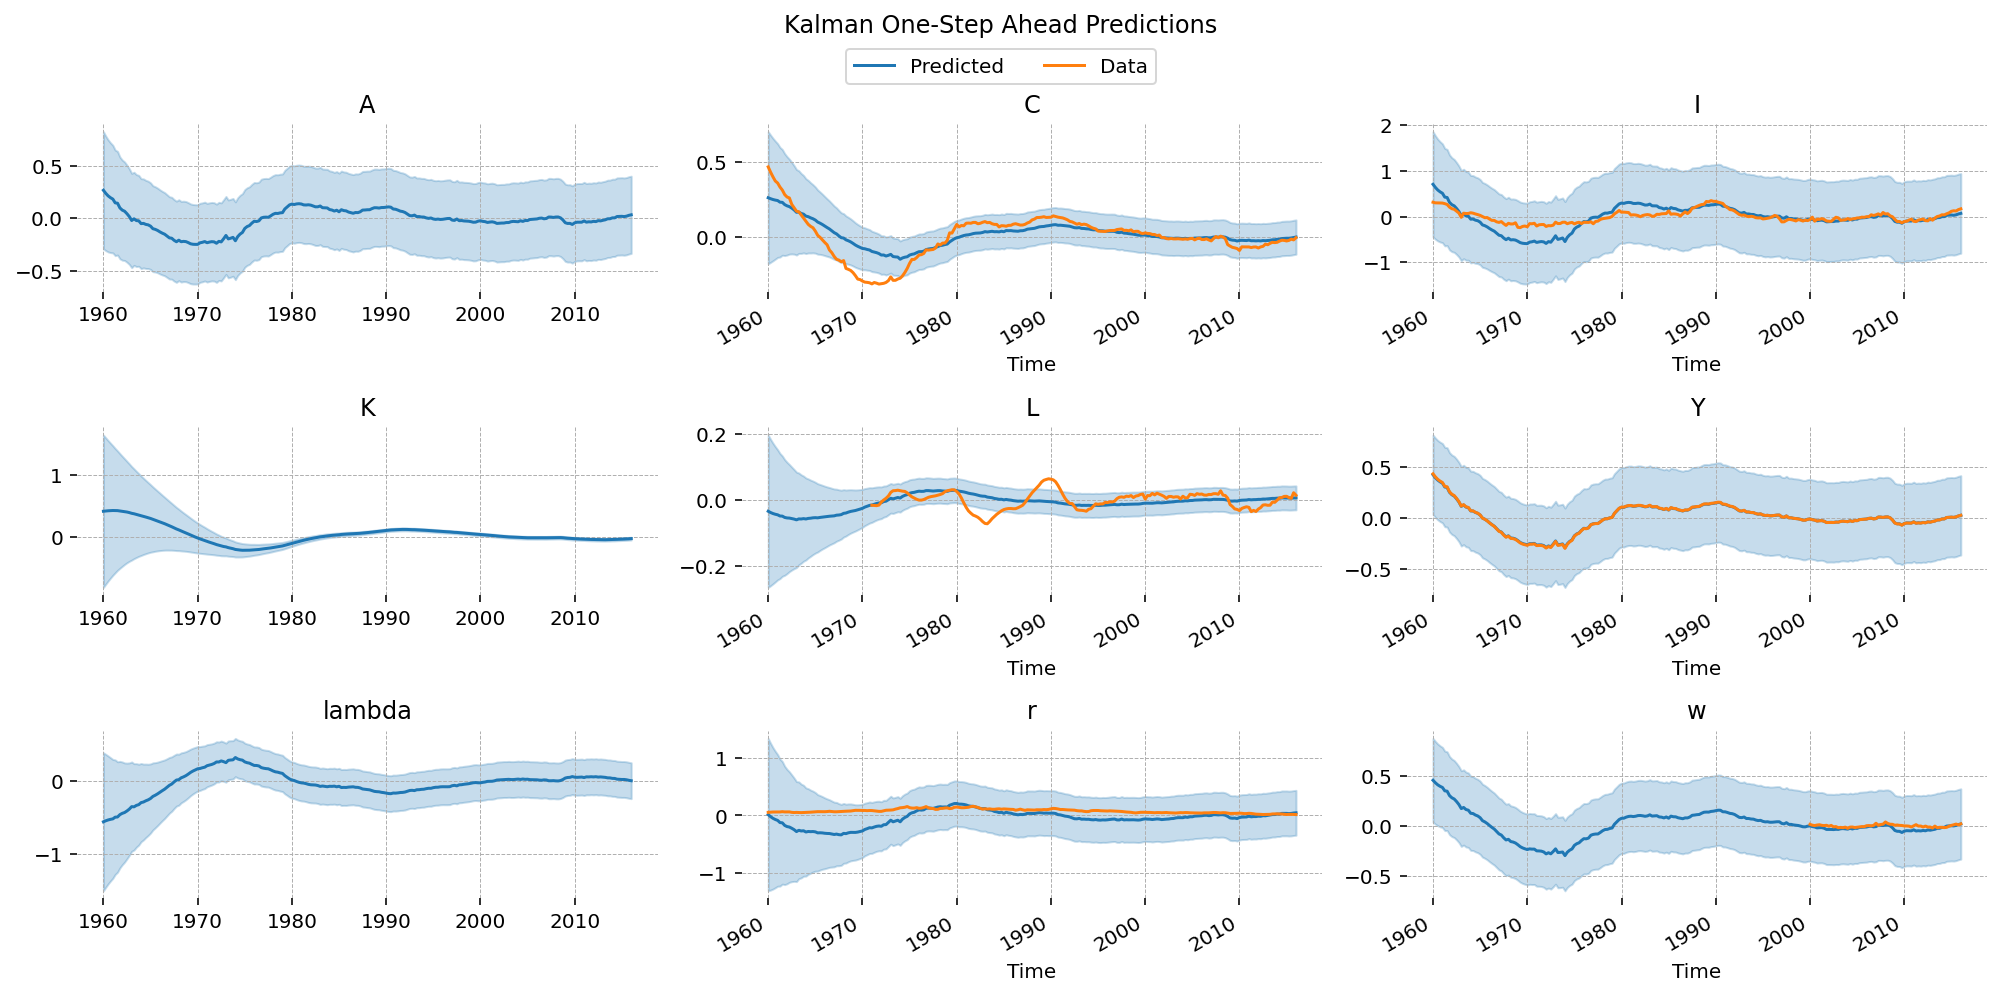

In [58]:
plot_sm_results(three_var_res, df_train_processed, var_names=vars_to_plot)

L is better. C is almost inside the 95% confidence interval.

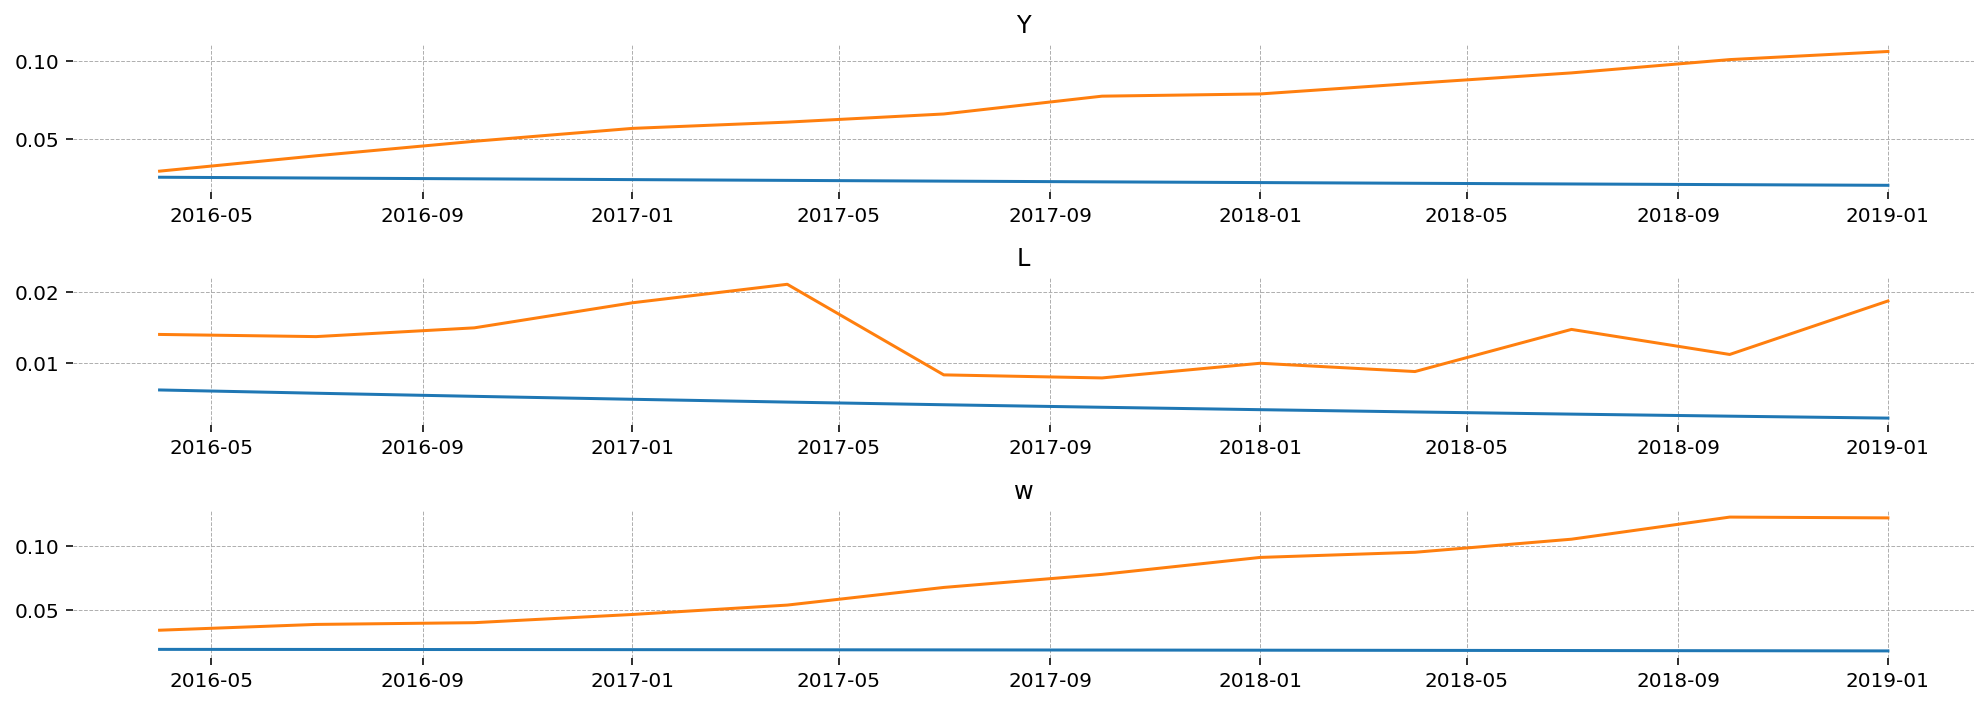

In [59]:
three_var_forecast = three_var_res.get_forecast(steps=n_test)
mu = three_var_forecast.predicted_mean

n_quarters = 12

fig, ax = plt.subplots(3, 1, figsize=(14,5))
for axis, var in zip(fig.axes, ['Y', 'L', 'w']):
    axis.plot(mu[var].iloc[:n_quarters])
    axis.plot(df_test_processed[var].iloc[:n_quarters])
    axis.set_title(var)
fig.tight_layout()
plt.show()

When we add wage as a dependent variable in order to build a three-variable model, p-values increased significantly and our coefficient for ρA decreases to 0.9501, which makes the technology shock less persistent.

## Adding Everything to the Model

In [60]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.95,
                    'sigma_C':1.5651,
                    'sigma_L':2.5147,
                    'alpha':0.35,
                    'beta':0.995,
                    'delta':0.025}

shock_start_dict = {'epsilon_A':0.05}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.05,
                    'w':0.10,
                    'r':0.05,
                    'C':0.05,
                    'I':0.05}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=1.1, high=5.0),
                    'sigma_L':IntervalTransformer(low=1.1, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
everything_mod = MLEModel(df_train_processed[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [61]:
# since we're going for so many parameters, increase maxiter
everything_res = everything_mod.fit(method='basinhopping', 
                                    niter=200,
                                    stepsize=0.25,
                                    minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f 33.6167
basinhopping step 1: f 5.45838 trial_f 5.45838 accepted 1  lowest_f 5.45838
found new global minimum on step 1 with function value 5.45838
basinhopping step 2: f 3.45312 trial_f 3.45312 accepted 1  lowest_f 3.45312
found new global minimum on step 2 with function value 3.45312
basinhopping step 3: f 4.95988 trial_f 4.95988 accepted 1  lowest_f 3.45312
basinhopping step 4: f 4.95988 trial_f 6.98703 accepted 0  lowest_f 3.45312
basinhopping step 5: f 4.95988 trial_f 21.2175 accepted 0  lowest_f 3.45312
basinhopping step 6: f 4.95988 trial_f 9.87018 accepted 0  lowest_f 3.45312
basinhopping step 7: f 4.95988 trial_f 10.0426 accepted 0  lowest_f 3.45312
basinhopping step 8: f 4.95988 trial_f 7.33128 accepted 0  lowest_f 3.45312
basinhopping step 9: f 4.95988 trial_f 6.36077 accepted 0  lowest_f 3.45312
basinhopping step 10: f 5.62421 trial_f 5.62421 accepted 1  lowest_f 3.45312
basinhopping step 11: f 5.62421 trial_f 29.0505 accepted 0  lowest_f 3.45312
basin

In [63]:
everything_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                  225
Model:                                  DSGEModel   Log Likelihood                 -12.864
Date:                            Tue, 03 Jan 2023   AIC                             49.729
Time:                                    10:26:07   BIC                             90.722
Sample:                                01-01-1960   HQIC                            66.274
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9539      0.286      3.340      0.001       0.394       1.514
sigma_C              3.6187     23.701      0.153      0.879     -42.834      50.072
sigma_L              3.7223     66.795      0.056      0.956    -127.193     134.638
alpha                0.4354      1.897      0.229      0.818      -3.283       4.154
beta                 0.9967      0.124      8.009      0.000       0.753       1.241
delta                0.0263      0.114      0.232      0.817      -0.196       0.249
sigma2.epsilon_A     0.0456      0.396      0.115      0.908      -0.731       0.823
sigma2.L             0.0431      0.035      1.216      0.224      -0.026       0.112
sigma2.w            28.7664     11.600      2.480      0.013       6.031      51.501
sigma2.r             0.2318      0.897      0.258      0.796      -1.527       1.991
sigma2.C             0.0634      0.205      0.309      0.758      -0.339       0.466
sigma2.I             0.4602      3.844      0.120      0.905      -7.074       7.995
======================================================================================================================================
Ljung-Box (L1) (Q):     12.81, 218.98, 189.56, 221.44, 215.88, 211.69   Jarque-Bera (JB):   394.28, 10.64, 447.40, 11.99, 22.91, 12.91
Prob(Q):                           0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                   0.00, 0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):             0.13, 1.56, inf, 0.11, 0.04, 0.03   Skew:                      0.75, 0.04, 2.37, 0.48, -0.72, 0.55
Prob(H) (two-sided):               0.00, 0.05, 0.00, 0.00, 0.00, 0.00   Kurtosis:                   9.31, 4.06, 8.02, 2.42, 3.62, 3.41
======================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

Consider the new fitted values for our parameters in the regression table above. Note, our calibrated parameter values were as follows:
β = 0.995, δ = 0.025, α = 0.35, σc = 1.5651, σl = 2.5147, ρA = 0.95, σεA = 0.05.

Our fitted values show an increase in the time discount factor, suggesting households are less impatient and value future consumption more evenly with current consumption. δ, the depreciation rate of capital decreases from its initial value of 0.025 to 0.0229. Our model predicts that the depreciation rate of capital is lower than the starting value we calibrated from Litsios et al. (2021) and Milliard et al. (1999). Similarly, α has also increased. Our fitted values show productiont to be more elastic to capital than suggested in the literature (see Litsios et al., 2021). σc is fitted at 2.0317 in the regression, much higher than our starting value of 1.5651 taken from Lyu et al. (2022). The opposite can be said for σl, the marginal disutility with respect to work, which lowers from our starting value of 2.5147 to 1.5910. The negative marginal effect of working on utility is lower in the UK than originally thought and recorded in the literature (see Lyu et al. (2022)). ρA is an important parameter value to discuss. Being the strength of the autoregressive component in technology, ρA determines the persistence of shocks for this state variable. We calibrated ρA to be 0.95, a very conventional value used in Costa (2018). Our fitted values record ρA to be 0.9827, slightly higher than what we started with. While seemingly small, the higher value can have a large effect on the variables that drive our model and therefore all our results. A higher ρA means that the current period's technology level is more strongly correlated with the last period's technology. This means a greater persistence of shock, and any positive or negative shock on technology (which has residual effects on all other variables) will take longer to return to the steady state. 

All of our regressed parameter values exhibit the same sign as in the literature (being >0), but the statistical significance is threatened. Indeed, we can only reject the null hypothesis that the parameter has no effect on the data at 90% confidence for ρA and β.

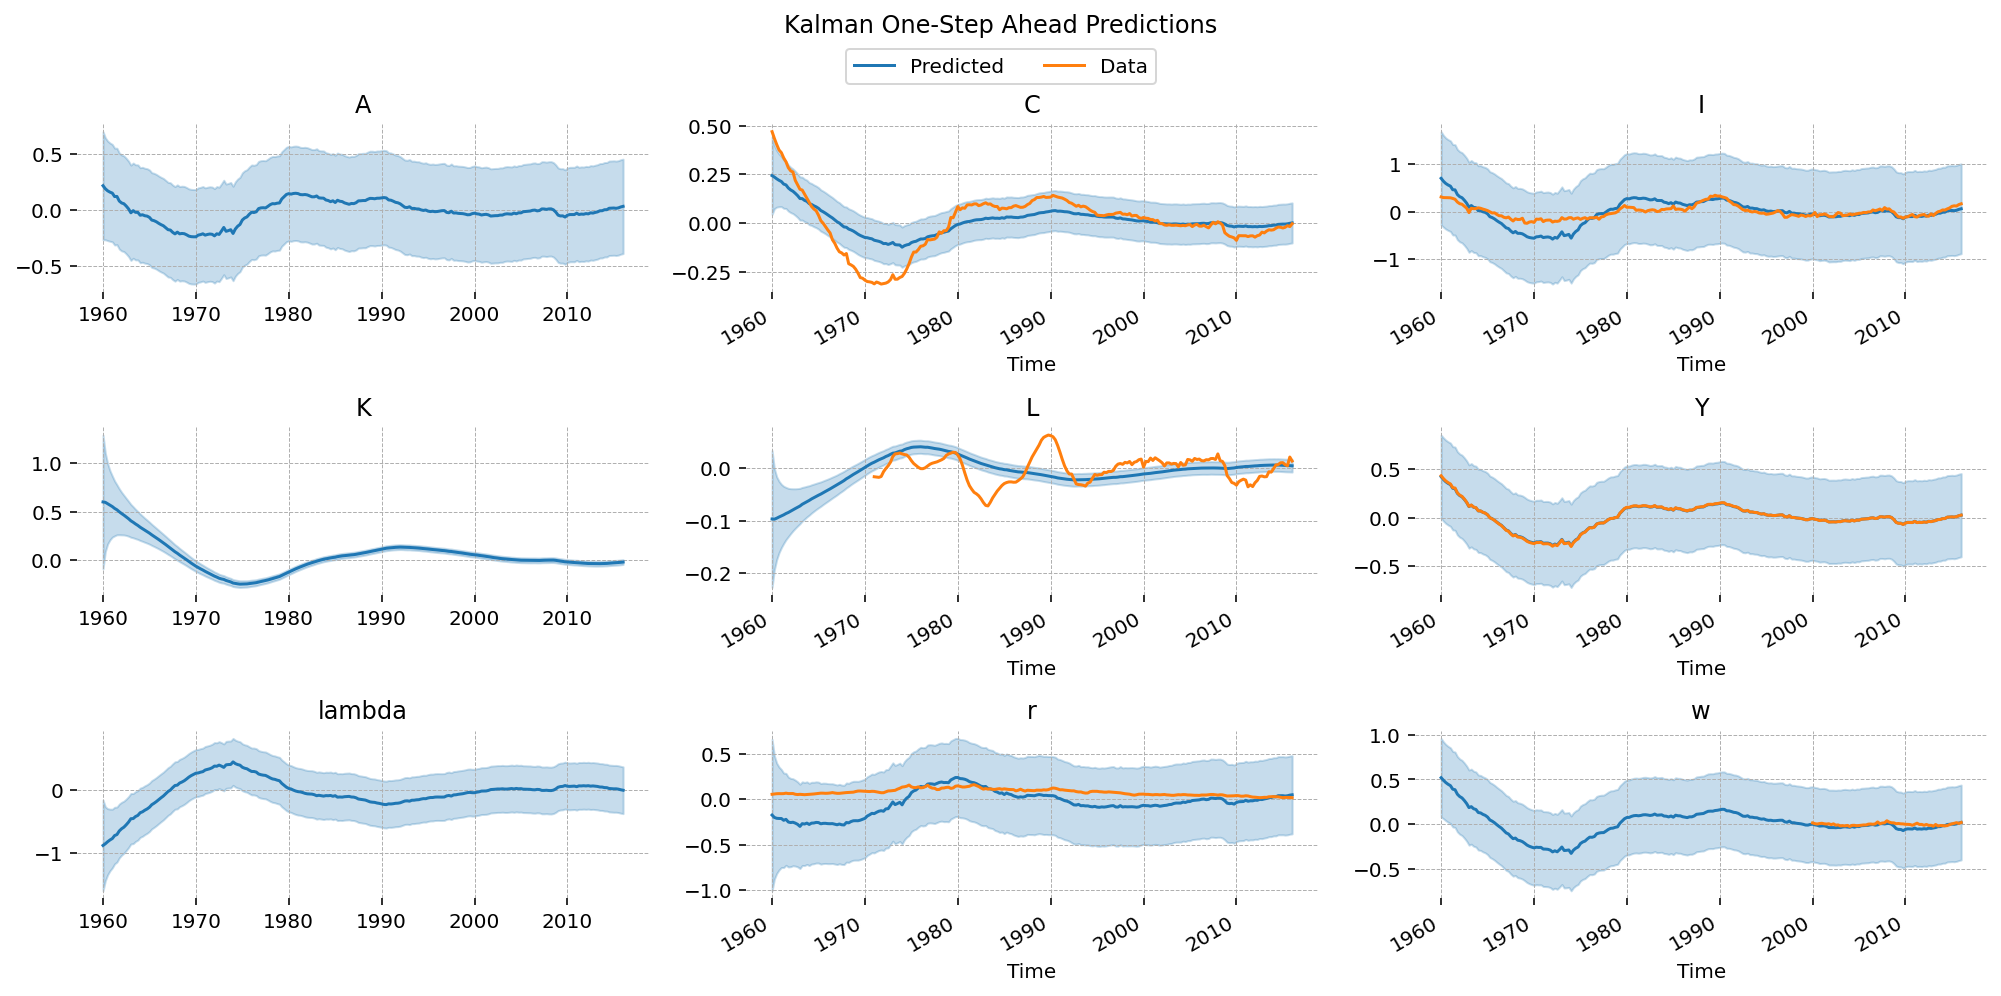

In [64]:
plot_sm_results(everything_res, df_train_processed, var_names=vars_to_plot)

The shape of our predictions is much the same as before. However, the confidence intervals for investment have slightly increased and the mean for labour is predicted as lower all across the board but still poorly predicted.

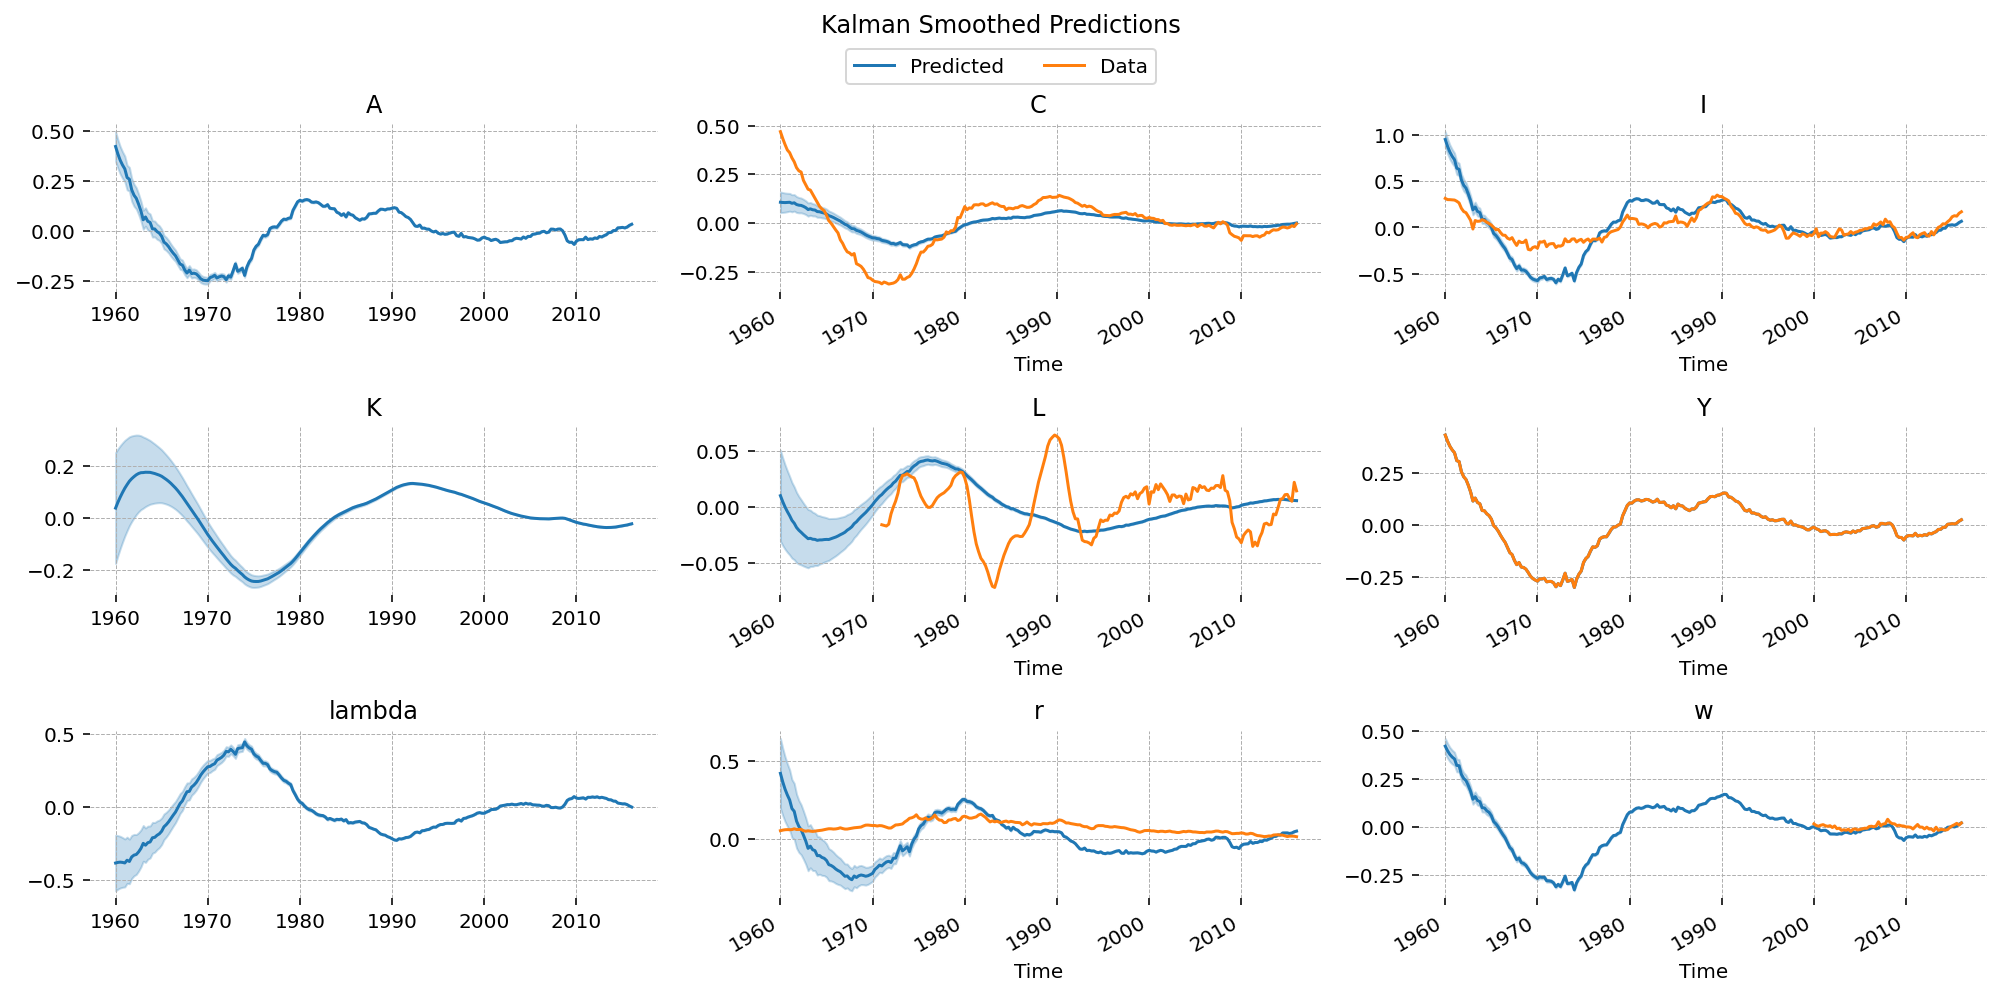

In [65]:
plot_sm_results(everything_res, df_train_processed, 'smoothed', var_names=vars_to_plot)

Looking at our forecasts investment seems quite good. The predictions track the data fairly well, but it looks as though our prediction cannot incorporate all the volatility present in investment, and we see the data depart and increase away from our prediction in the 2015 area.

Interest rates aren't predicted well and our mean seems to be too high. Wage isn't too bad either, but there is little volatility in the data to throw our predictions off. L again shows sharp oscillations which our model cannot predict. 

A and K appear closely correlated. Consumption and L appear to move in the same direction, but labour is not as volatile. IT also appears that at the same time labour increases/decreases, capital decreases/increases. As they are imperfect substitutes in the production function this makes sense. For example, during the 1970s when labour is at a high, capital is at an all time low. Investment is also very low. L is clearly an important driver of K which makes sense. Perhaps when wages are low (as seen during this period also) people work more because they cannot afford not to work, but also cannot afford to save much and invest, so we see capital decrease (because capital accumulation is dependent on investment). This is the same in 1990, where capital is high but labour supply is low. This is an interesting observation and appears grounded in economic theory. The UK also experienced a recession in the early 1990s caused by the US savings and loan crisis (Catao & Ramaswamy, 2016).

Capital and technology appear correlated but there is a lag. For example, when we see capital reach its trough in 1975 and begin to climb, technlogy is already on its way up.

Regarding wage, our model over-predicts the drop in wages experienced at the time of the 2008 financial crisis. Our collected data is fairly consistent and stable, but our predictions are more volatile.

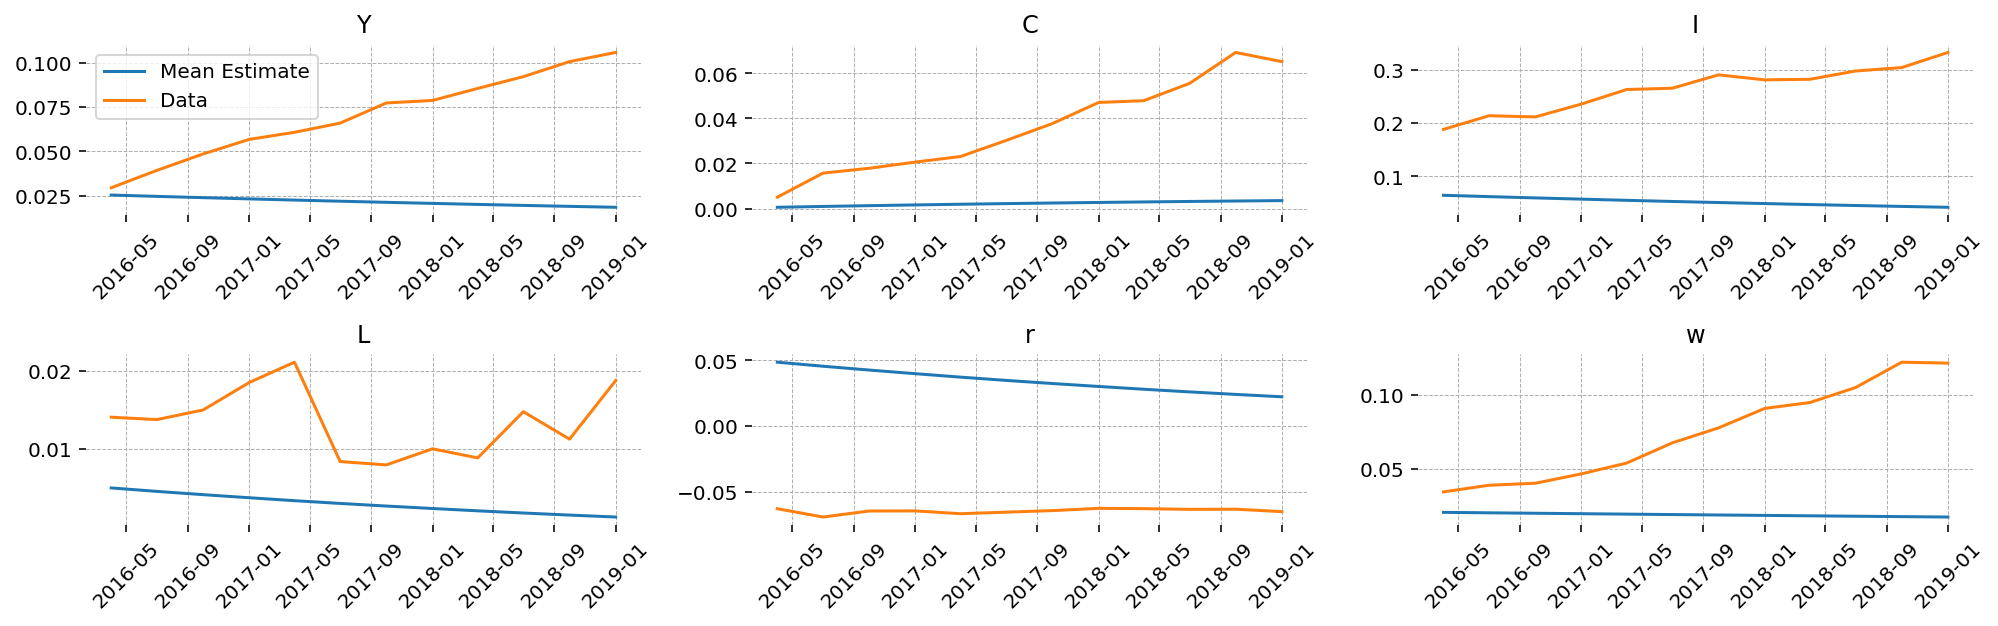

In [66]:
everything_forecast = everything_res.get_forecast(steps=n_test)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'C', 'I', 'L', 'r', 'w'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(df_test_processed[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

In [67]:
rbc.free_param_dict

{'alpha': 0.43537375851444515,
 'beta': 0.9967037934197673,
 'delta': 0.026347963108056566,
 'rho_A': 0.9538507243071517,
 'sigma_C': 3.6186579147670717,
 'sigma_L': 3.7223243056505533}

In [68]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

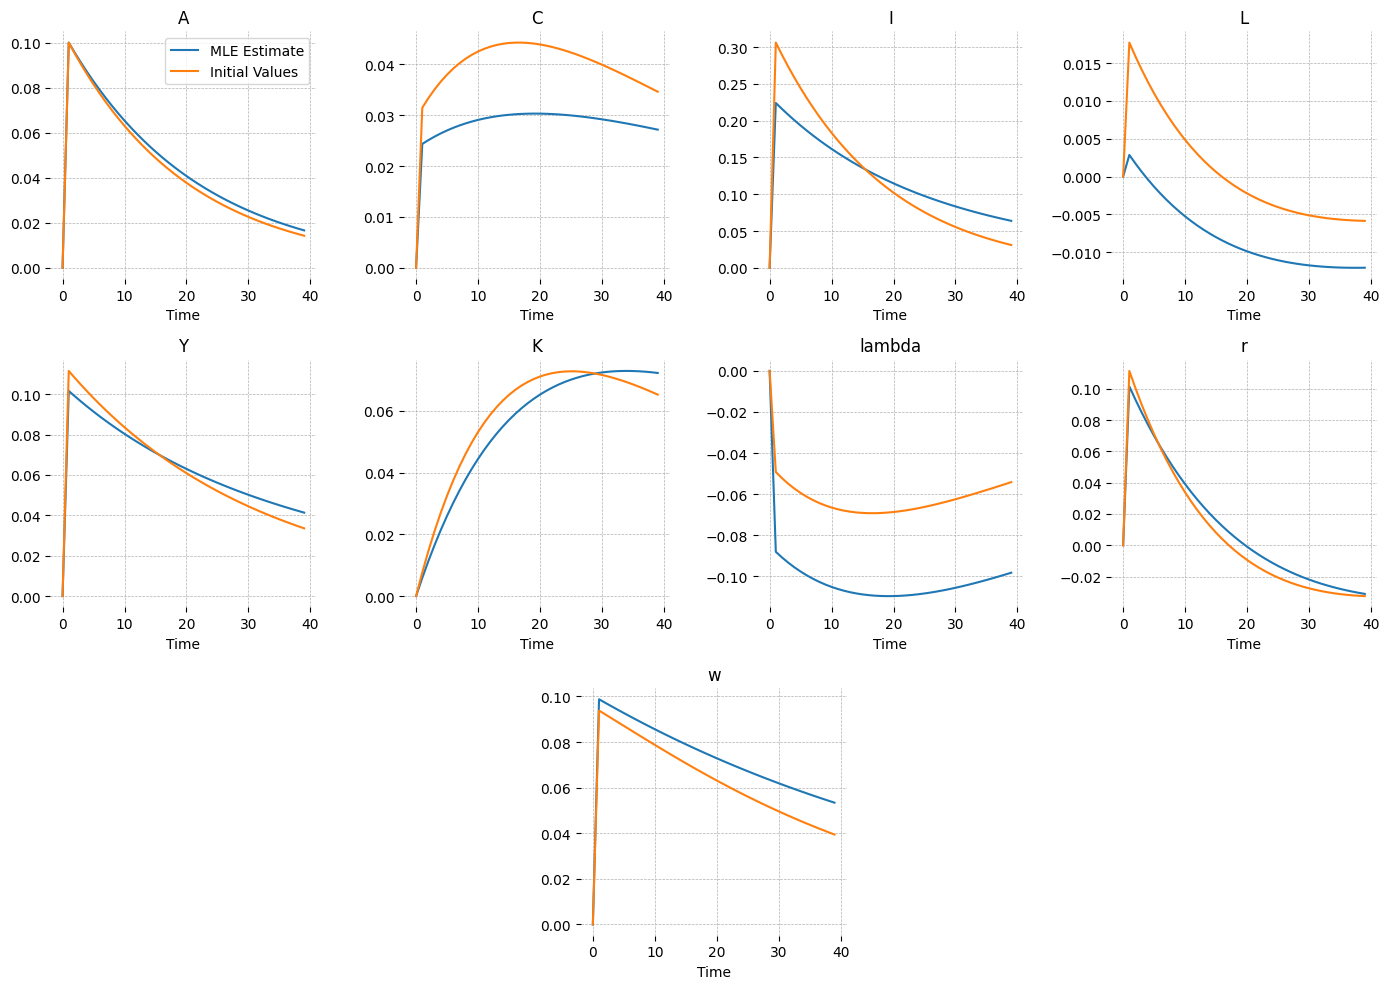

<Figure size 1400x1000 with 0 Axes>

In [69]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=vars_to_plot)
fig2 = gp.plot_irf(base_irf, vars_to_plot=vars_to_plot)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()


This figure shows the effect of a positive technology shock on our UK-calibrated model. 

We see technology instantly climb to 0.1 where it starts to decline with a rate corresponding to ρA. 

The marginal productivities of labour and capital increase and firms increase their demand. Labour is faster to respond to the shock than capital. This has an effect on the prices of labour and capital, namely wage and the rental rate, so we see these increase as well. Higher incomes given by the higher wages increases consumption and investment. But, as wages decline and the shock disspiates, labour declines and brings with it capital, consumption and investment. Consumption is less volatile than investment to the decline in wages and shows more of a hump shape. This is plausible because households try to smooth their consumption over time. So, consumption responds slower both on the uptake and on the decline.

Positive technology shocks increase consumption and investment (fuelled by higher household incomes), which result from greater demand for productive inputs (Costa, 2018). Output closely tracks investment but you can see the warp in the response where consumption peaks (around period 15). This is because output is an aggregate of consumption and investment (see model equations).

## The New Steady State

In [70]:
rbc.steady_state()

Steady state found! Sum of squared residuals is 1.9724604118436315e-29


In [71]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.737
I_ss               1.726
K_ss              65.524
L_ss               0.562
Y_ss               4.463
lambda_ss          0.026
r_ss               0.030
w_ss               4.482


Our previous steady state:

A_ss               1.000;
C_ss               2.273;
I_ss               0.935;
K_ss              37.401;
L_ss               0.855;
Y_ss               3.209;
lambda_ss          0.277;
r_ss               0.030;
w_ss               2.439.

When comparing the steady states of a large and open economy such as the United states, and a relatively smaller economy like that of the United Kingdom we can see that the steady states are initially fairly similar, with the relative differences being mostly irrelevant. The main difference comes after all the observational noise, in the form of shocks / variance terms, has been added to the various variables. This changes the values of the steady states as these new parameters influence the results of the perturbation solutions which yield new steady state solutions.

Comparing our new calibrated steady state to the steady state found using our initial parameter values, we see some important changes.

The steady state consumption increases, but not by much. We can see that this is accompanied out by an increase in investment from 0.935 to 1.726. Because of this greater investment at the steady state, the steady state level of capital is much higher (almost double). This is charactertistic of a high saving, high investment, capital oriented developed nation, as we would expect from the UK and as seen in the literature. This is likely contributed to by the higher calibrated value of α, meaning production is more elastic to capital employment. The higher relative elasticity of capital to labour means more capital is employed, hence the higher investment, and the lower labour supply steady state.

Consider now GDP in the steady state. We originally computed 3.209 to be the steady state GDP level, but re-computation with our fitted values records a higher value of 4.463. This is to be expected with the massively increased steady state capital, and the slight increase in consumption. The rental rate of capital in the steady state is identical to our original computation, but our model predicts a higher steady state wage. The higher wage is needed to keep budgets balanced with the greater consumption and investment and avoid a tradeoff between the two.

In short, our model predicts key structural steady state variable values to be higher than in our original computation with literature-calibrated parameter values. We see a jump in the wage, giving households bigger budgets which is allocated largely to investment. Consumption increases, and the greater allocation of the higher wage to capital investment coupled with the greater production function elasticity to capital fuels higher a higher output level in the steady state. Increased wages and more employment of capital in the production process encourages less time spent working which is interesting given that our marginal disutility w.r.t. working decreased (in the above section).

Much of the literature we reviewed, while UK focused, is U.S. orientated like much of economic literautre. It is likely that a lot of the 'conventional' parameter values we used in our original computation are U.S. biased and this could explain some of the differences between our orignal computation and our computation with our fitted values. As seen in the literature review, the labour markets of the UK and U.S. behave differently.

## Bibliography

Blanchard, O.J. and Kahn, C.M., 1980. The solution of linear difference models under rational expectations. Econometrica: Journal of the Econometric Society, pp.1305-1311.

Catão, L. and Ramaswamy, R., 1996. Recession and Recovery in the United Kingdom in the 1990s: Identifying the Shocks. National Institute Economic Review, 157, pp.97-106.

Costa, C., 2018. Understanding dsge models: theory and applications. Vernon Press.

Darby, M.R. and Lothian, J.R., 1983, January. British economic policy under Margaret Thatcher: A midterm examination. In 

Carnegie-Rochester Conference Series on Public Policy (Vol. 18, pp. 157-207). North-Holland.

Harrison, R. and Oomen, O., 2010. Evaluating and estimating a DSGE model for the United Kingdom.

Hinterschweiger, M., Khairnar, K., Ozden, T. and Stratton, T., 2021. Macroprudential policy interactions in a sectoral DSGE model with staggered interest rates.

Holland, A and Scott, A (1996), ‘The determinants of United Kingdom business cycles’, Bank of England Working Paper. 

Litsios, I., Pilbeam, K. and Asteriou, D., 2021. DSGE modelling for the UK economy 1974–2017. Bulletin of Economic Research, 73(2), pp.295-323.

Lyu, J., Vo Phuong, M.L., Meenagh, D. and Minford, A., 2022. UK monetary policy in an estimated DSGE model with financial frictions. Journal of International Money and Finance.

Millard, S., Scott, A. and Sensier, M., 1999. Business cycles and the labour market: Can theory fit the facts?.

Office for National Statistics (ONS), Employment and Labour Statistics,  released 21 November 2022, ONS website, statistical bulletin, https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/timeseries/ybuy/lms. Accessed December 4, 2022.

Office for National Statistics (ONS), released 21 November 2022, ONS website, statistical bulletin, https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ybha/pn2. Accessed December 4, 2022.

Organization for Economic Co-operation and Development, 3-Month or 90-day Rates and Yields: Interbank Rates for the United Kingdom [IR3TIB01GBQ156N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IR3TIB01GBQ156N, December 3, 2022.

Organization for Economic Co-operation and Development, Gross Fixed Capital Formation in United Kingdom [GBRGFCFQDSMEI], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GBRGFCFQDSMEI, December 3, 2022.

Organization for Economic Co-operation and Development, Private Final Consumption Expenditure in United Kingdom [GBRPFCEQDSMEI], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GBRPFCEQDSMEI, December 3, 2022.

Ravn, M.O., 1997. Permanent and transitory shocks, and the UK business cycle. Journal of Applied Econometrics, 12(1), pp.27-48.
